# Test  AI Agent framework  AI A real estate agent 

In [37]:
import os , json, time , gc
import logging


from dotenv import load_dotenv
from IPython.display import display, HTML, Markdown
from tqdm import tqdm
from openai import OpenAI, AsyncOpenAI
from openai.types.chat import (ChatCompletion, 
                               ChatCompletionChunk,
                               ChatCompletionContentPartTextParam, 
                               ChatCompletionContentPartImageParam,
                               ChatCompletionStreamOptionsParam)
import asyncio
import aiohttp
import pandas as pd
import re
import torch
import mlflow

import nest_asyncio
nest_asyncio.apply() # for jupyter notebook

In [38]:
# import crewai AI agent framework # pip install crewai
from crewai import Crew, Agent, Task, Process 

from crewai_tools import ScrapeWebsiteTool, SerperDevTool
from crewai.tools import BaseTool, tool
from crewai import LLM
from pydantic import BaseModel, Field
from typing import List, Dict, Type
from crewai.project import CrewBase, agent, task, crew

import crewai
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any

from crewai.memory import LongTermMemory, ShortTermMemory, EntityMemory
from crewai.memory.storage.rag_storage import RAGStorage
from crewai.memory.storage.ltm_sqlite_storage import LTMSQLiteStorage
from typing import List, Optional
from crewai_tools import ScrapeWebsiteTool, SerperDevTool


In [39]:
# Crawl4AI is a web crawling and data extraction library designed for AI applications.

from crawl4ai import  AsyncWebCrawler, BrowserConfig, CrawlerRunConfig, CacheMode
import crawl4ai


from crawl4ai.chunking_strategy import (RegexChunking, 
                                        NlpSentenceChunking,
                                        OverlappingWindowChunking, 
                                        SlidingWindowChunking,
                                        FixedLengthWordChunking, 
                                        TopicSegmentationChunking) 

from crawl4ai.extraction_strategy import ( JsonCssExtractionStrategy, 
                                           JsonXPathExtractionStrategy,
                                          LLMExtractionStrategy, 
                                          CosineStrategy)
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator


from crawl4ai.content_filter_strategy import BM25ContentFilter, PruningContentFilter, LLMContentFilter

In [40]:
class CFG:

    USE_OPIK = False # for OPIK local LLM framework evaluation

    opikURL = "http://localhost:5173"

    mlflow_experiment_name = "AI-real-estate-agent-by-multimodal"
    mlflow_tracking_uri = "http://localhost:5000"

     # Set LLM host framework
    USE_OLLAMA = True # for OLLAMA local LLM framework
    USE_OPENROUTER = False # for OpenRouter LLM framework
    USE_OPENAI = False # for OpenAI LLM framework

    # search engine
    num_results = 3 # 5
    queryTime = "month" #"year"

    # Azure Opena Model
    llmModel1 = "gpt-4o-mini"
    llmModel2 = "gpt-4o"
    embedModel1 = "text-embedding-3-small" #1528 openai embedding model
    embedModel2 = "text-embedding-3-large"  # around 3000 dimension
    embedModel3 = "text-embedding-ada-002"
    embedModel4 = "azure-text-embedding-3-small"
    embedModel5 = "azure-text-embedding-3-large"

  
    
    openEmbedModel1 = "intfloat/multilingual-e5-small" # 512 dimension
    openEmbedModel2 = "sentence-transformers/distiluse-base-multilingual-cased-v1"
    openEmbedModel3 = "intfloat/multilingual-e5-large" # curent  # 1024 dimension 
    openEmbedModel4 = "Alibaba-NLP/gte-multilingual-base"
    openEmbedModel5 = "nomic-embed-text" # 768 dimension , support 8196 input 
    openEmbedModel6 = "mixedbread-ai/mxbai-embed-large-v1"  # 
    openEmbedModel7 =   "nomic-embed-text" 

    ollamallmModel1 = "ollama/deepseek-r1:8b"
    ollamallmModel2 = "ollama/deepseek-r1:7b"
    ollamallmModel3 = "ollama/qwen2.5" # Qwen 2.5 7B
    ollamallmModel4 = "ollama/llama3.2"
    ollamallmModel5 = "ollama/qwen3:8b" # Qwen 3 8B


    visionEmbedModel1 = "nomic-ai/nomic-embed-vision-v1.5"
    visionEmbedModel2 =  "openai/clip-vit-base-patch16" # openai vision embeding model 


    promptInjectModel1 = "protectai/deberta-v3-base-prompt-injection-v2"

    htmlMarkdownModel1 = "jinaai/reader-lm-0.5b"
    htmlMarkdownModel2 = "jinaai/reader-lm-1.5b"

    api_base1="http://localhost:11434" # Ollama API base URL

    # Load locally Open source Embedding model 
    modelPath = "./model" 
    fullModelPath = modelPath + "/" + openEmbedModel3

    #General chat completion
    stream = False
    top = 3
    max_tokens = 2048
    top_p = 1
    temperature = 0.5
    presence_penalty = 0
    frequency_penalty = 0


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [42]:
import sys
import os

# Add parent directory to sys.path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.utils import (set_log_level, extractURLs, extractMarkdown)
from web_search_searxg import asyncSearchURL, searchURL

logger = logging.getLogger(__name__)
set_log_level(logger, "DEBUG")


In [43]:
# os.path.abspath(os.path.join(os.getcwd(), '..'))

In [44]:
logger.info(f"Using device: {device}")

2025-09-09 23:52:29,549 - 128579020938112 - 841734249.py-841734249:1 - INFO: Using device: cuda


In [45]:
# set_log_level(logger, "DEBUG")

### Inital Opik for AI agent debug tool

In [46]:
import opik
from opik.integrations.crewai import track_crewai
from litellm.integrations.opik.opik import OpikLogger
from opik import track

import litellm
from litellm import acompletion


if CFG.USE_OPIK:
    opik.configure(use_local=True, automatic_approvals=True , url=CFG.opikURL)

    opikProjectName = "AI-Agent-Real-Estate-Recommender"
    track_crewai(project_name=opikProjectName)
    opik_logger = OpikLogger()
    litellm.callbacks = [opik_logger]

In [11]:
from langchain_ollama import OllamaLLM, ChatOllama
from langchain_openai import ChatOpenAI

In [12]:
import ctypes
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        ctypes.CDLL("libc.so.6").malloc_trim(0)
        gc.collect()
        time.sleep(0.3)

In [13]:
query="Find me a 3 bedroom house in Hong Kong under $5 million"

In [14]:
# from crewai_tools import BraveSearchTool

# # Initialize the tool for internet searching capabilities
# tool = BraveSearchTool()

# SearxNG Web Search Engine

You can [check this link](https://docs.searxng.org/dev/search_api.html) for more informations about `Searx API` parameters.
#### Download SearxNG docker for local host setup web search Engine

In [15]:
# %%time
queryTime = ""  #"month" #"year"#"month" #"year" #"day"
k = 5#5
currentQuery = "What is Hong Kong Weather Now?" #q2 #"Hong Kong Kwun Tong" #q3#tempQuery#q1
categories =  []#[""] #["science"]#["science", "image"]
# query_suffix = searchOptimalConfig #None #searchMapConfig   # searchVideoConfig
urls = await asyncSearchURL(currentQuery, k=k, qureyTime=queryTime, categories=categories)
urls

Time take: 1.681572437286377
Query Categores : []


[{'snippet': 'For detailed description of today\'s ... "Local Weather Forecast". The Probability of Significant Rain (PSR) forecast provides users with additional reference on rainfall amount and forecast trend for the coming 9 days. The PSR forecast on each day indicates the probability of the accumulated rainfall generally over Hong Kong reaching 10 ...',
  'title': '9-day Hong Kong weather forecast provided by the Hong Kong Observatory',
  'link': 'https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm',
  'engines': ['bing', 'duckduckgo', 'brave', 'yahoo'],
  'category': 'general'},
 {'snippet': "2 天前 · Get the latest hourly weather updates for Hong Kong today. Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about today's weather conditions in Hong Kong.",
  'title': "Today's Weather in Hong Kong - Hourly Forecast and Conditions",
  'link': 'https://www.easeweather.com/asia/hong-kong/today',
  'engines': ['bing', 'duckduckgo', 'yahoo'],
  'category':

In [16]:
df = pd.DataFrame(urls)
df

,snippet,title,link,engines,category
0,"For detailed description of today's ... ""Local...",9-day Hong Kong weather forecast provided by t...,https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm,"[bing, duckduckgo, brave, yahoo]",general
1,2 天前 · Get the latest hourly weather updates f...,Today's Weather in Hong Kong - Hourly Forecast...,https://www.easeweather.com/asia/hong-kong/today,"[bing, duckduckgo, yahoo]",general
2,At 9 p.m. at Hong Kong Observatory : Air Tempe...,Current Weather,https://www.hko.gov.hk/textonly/v2/forecast/en...,"[google, brave]",general
3,Cloudy; a couple of thunderstorms in the morni...,"Hong Kong, Sha Tin, Hong Kong Weather Forecast...",https://www.accuweather.com/en/hk/hong-kong/11...,"[brave, yahoo]",general
4,香港天文台是一個負責監測及預測天氣、並就與天氣有關的災害發出警告的政府部門。 天文台亦監測和...,香港天文台 - Hong Kong Observatory,https://www.weather.gov.hk/tc/index.html,"[bing, duckduckgo]",general


In [17]:
urlsList = extractURLs(urls) 
print(urlsList)

['https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm', 'https://www.easeweather.com/asia/hong-kong/today', 'https://www.hko.gov.hk/textonly/v2/forecast/englishwx2.htm', 'https://www.accuweather.com/en/hk/hong-kong/1123655/weather-forecast/1123655', 'https://www.weather.gov.hk/tc/index.html']


# Web scaping tool used Crawl4AI tool base on Playwrigth and Chrowmimum browswer


In [18]:
# Bros
# Test  playwright engine
from playwright.async_api import async_playwright

async def playwrightTestWeb():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True) # launch browser
        page = await browser.new_page()
        await page.goto('https://www.google.com')
        print(f"Title of the page: {await page.title()}")
        await page.screenshot(path='example.png')# save screenshot
        await browser.close()

In [19]:
await playwrightTestWeb() # test the browser pylaywright engine

Title of the page: Google


In [ ]:

from web_scraping_crawl4ai import getWebPageContentsConcurrent, getWebPageContent

# Single URL Web scraping test

In [22]:
rst = await (getWebPageContent(df.iloc[0].link)) # Get the content of the first URL

[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 1.00s 

[SCRAPE].. ◆ https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 0.23s 

[COMPLETE] ● https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 1.23s 

{'url': 'https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm',
 'html': '<!DOCTYPE html><html lang="en" dir="ltr"><head>\n    <meta charset="UTF-8">\n    <title>9-day Weather Forecast for Hong Kong｜Hong Kong Observatory(HKO)｜Weather Forecast</title>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <meta name="keywords" content="9-day Weather Forecast for Hong Kong">\n    <meta name="description" content="9-day Hong Kong weather forecast provided by the Hong Kong Observatory">\n    <meta name="recordId" content="2018123100000035863">\n    <meta name="lang" content="en">\n\t<meta property="fb:app_id" content="468280339992518">\n\t<meta property="og:type" content="website">\n\t<meta property="og:title" content="9-day Hong Kong weather forecast provided by the Hong Kong Observatory">\n\t<meta property="og:description" content="9-day Hong Kong weather forecast provided by the Hong Kong Observatory">\n\t<m
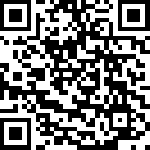

In [23]:
(rst[0].model_dump())

In [24]:
for item in rst:
    print(f"URL: {item.url}")
    # print(f"Title: {item.title}")
    print(f"Content: {item.html[:200]}...")  # Print first 200 characters of content
    # print(f"Images: {item.images}")
    print(f"Links: {item.links}")
    print(f"Markdown: {item.markdown[:200]}...")
    print(f"Metadata: {item.metadata}")  
    # print(f"Text: {item.text[:200]}...")  # Print first 200 characters of text
    print("-" * 80)  # Separator for readability

URL: https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm
Content: <!DOCTYPE html><html lang="en" dir="ltr"><head>
    <meta charset="UTF-8">
    <title>9-day Weather Forecast for Hong Kong｜Hong Kong Observatory(HKO)｜Weather Forecast</title>
    <meta http-equiv="X-U...
Links: {'internal': [{'href': 'https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm/#mainContentSkip', 'text': 'Skip to main content', 'title': 'Skip to main content', 'base_domain': 'hko.gov.hk'}, {'href': 'https://www.hko.gov.hk/en/wxinfo/index.html', 'text': '', 'title': '', 'base_domain': 'hko.gov.hk'}, {'href': 'https://www.hko.gov.hk/en/wxinfo/gts/time/conversion.htm', 'text': '', 'title': 'Gregorian/Lunar Calendar', 'base_domain': 'hko.gov.hk'}, {'href': 'https://www.hko.gov.hk/en/wxinfo/other/textsize.html', 'text': 'Text Size', 'title': '', 'base_domain': 'hko.gov.hk'}, {'href': 'https://www.hko.gov.hk/en/wxinfo/bookmark.html', 'text': 'Bookmark', 'title': '', 'base_domain': 'hko.gov.hk'}, {'href': 'https://www.hko.gov.h

In [25]:
# urls = extractURLs(rst)

In [26]:
markdowns = extractMarkdown(rst, types="all", extract="raw_markdown")

Markdown: [Skip to main content](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mainContentSkip "Skip to main content")
[![Hong Kong Observatory](https://www.hko.gov.hk/images/logo_hko_inside_e.png)](https://w...


In [27]:
Markdown(markdowns[0])

[Skip to main content](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mainContentSkip "Skip to main content")
[![Hong Kong Observatory](https://www.hko.gov.hk/images/logo_hko_inside_e.png)](https://www.hko.gov.hk/en/index.html)
Personalized Website![Personalized Website](https://www.hko.gov.hk/images/PersonalizedIcon.png)Share![Share](https://www.hko.gov.hk/images/icon_share.png)Search![Search](https://www.hko.gov.hk/images/icon_search.png)Language![Language](https://www.hko.gov.hk/images/icon_language.png)Menu![Menu](https://www.hko.gov.hk/images/btn_mobileMenu.png)
9 Sep 2025 (Tue)
[![Gregorian/Lunar Calendar](https://www.hko.gov.hk/images/icon_date.png)](https://www.hko.gov.hk/en/gts/time/conversion.htm "Gregorian/Lunar Calendar")
![Light Rain](https://www.hko.gov.hk/images/HKOWxIconOutline/Outline_wxicon_pic62.png)
28.2°C
86%
(23:30)
  * [繁繁](javascript:chglang\(1\))
  * [简简](javascript:chglang\(2\))


[Text Size](https://www.hko.gov.hk/en/other/textsize.html)
[![Bookmark](https://www.hko.gov.hk/images/icon_bookmark_setting.png)Bookmark](https://www.hko.gov.hk/en/bookmark.html)
[![Share](https://www.hko.gov.hk/images/icon_share.png)](javascript:trigger_shareTool\(\))
[This link will open in a new window![Facebook](https://www.hko.gov.hk/images/follow/fb.png)](https://www.facebook.com/sharer/sharer.php?u=https%3A%2F%2Fwww.hko.gov.hk%2Fen%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[This link will open in a new window![X](https://www.hko.gov.hk/images/follow/x_black_100px.png)](https://x.com/intent/tweet?url=https%3A%2F%2Fwww.hko.gov.hk%2Fen%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[This link will open in a new window![Weibo](https://www.hko.gov.hk/images/follow/sina.png)](http://service.weibo.com/share/share.php?url=http%3A%2F%2Fwww.hko.gov.hk%2Fen%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[![Email](https://www.hko.gov.hk/images/follow/email.png)](javascript:email\(\))[![QR Code](https://www.hko.gov.hk/images/icon_qrcode.png)](javascript:showQrcode\(\))
[![SEARCH](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
[![SEARCH](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
  * [WeatherExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)Local Weatherrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=8)
      * [Regional Weather](https://www.hko.gov.hk/en/wxinfo/ts/index.htm)
      * [Weather Photo](https://www.hko.gov.hk/en/wxinfo/ts/index_webcam.htm)
      * [Rainfall Distribution Map](https://www.hko.gov.hk/en/wxinfo/rainfall/item_list.htm)
      * [Ultraviolet (UV) radiation information](https://www.hko.gov.hk/en/wxinfo/uvinfo/uvinfo.html)
      * [Visibility Readings in Hong Kong Waters](https://www.hko.gov.hk/en/vis/vis_index.shtml)
      * [Weather Report](https://www.hko.gov.hk/en/wxinfo/currwx/current.htm)
      * [Yesterday's Weather and Radiation Level](https://www.hko.gov.hk/en/wxinfo/pastwx/ryes.htm)
      * [Past Weather](https://www.hko.gov.hk/en/wxinfo/pastwx/past.htm)
      * [Upper-air Observations in Hong Kong](https://www.hko.gov.hk/en/out_photo/upper-air-weather.htm)
      * [King's Park Meteorological Station](https://www.hko.gov.hk/en/wxinfo/aws/kpinfo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)Weather Forecastrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=15)
      * [Local Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/flw.htm)
      * [9-Day Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Special Weather Tips](https://www.hko.gov.hk/en/sweather_tips.html)
      * [Extended Outlook](https://www.hko.gov.hk/en/probfcst/tempfcst.htm)
      * [This link will open in a new windowAutomatic Regional Weather Forecast](https://maps.weather.gov.hk/ocf/index_e.html)
      * [This link will open in a new windowTwo-hour Rainfall Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncrf)
      * [This link will open in a new windowOne-hour Lightning Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncln)
      * [UV Index Forecast](https://www.hko.gov.hk/en/wxinfo/uvinfo/uvinfo.html)
      * [South China Coastal Waters](https://www.hko.gov.hk/en/wxinfo/currwx/ffish.htm)
      * [Marine Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fmar.htm)
      * [Computer Forecast Weather Map](https://www.hko.gov.hk/en/nhm/nhme.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/today_weather.png)Weather Warningsrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=25)
      * [Today's Weather Warnings](https://www.hko.gov.hk/en/wxinfo/dailywx/wxwarntoday.htm)
      * [Warning Information](https://www.hko.gov.hk/en/detail.htm)
      * [Regional Info on Heavy Rain & Thunderstorms](https://www.hko.gov.hk/en/rhr/main.html)
      * [Tropical Cyclone Warning (Local)](https://www.hko.gov.hk/en/wxinfo/currwx/tc.htm)
      * [Details of Warnings](https://www.hko.gov.hk/en/wservice/warning/details.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/fishermen.png)Weather for Fishermen](https://www.hko.gov.hk/en/fishermen/main.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/marine.png)Weather for Marinerelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=1370)
      * [Weather Information for the Marine Community](https://www.hko.gov.hk/en/wservice/tsheet/pms/mariners.htm)
      * [Port Meteorological Services](https://www.hko.gov.hk/en/wservice/tsheet/pms/index.htm)
      * [This link will open in a new windowMyOceanWeather Gallery](https://maps.weather.gov.hk/sea/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)Weather for Aviation](https://www.hko.gov.hk/en/aviat/amt/amsmain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wx-1.png)Weather Monitoring Imageryrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=1323)
      * [Radar Imagery](https://www.hko.gov.hk/en/wxinfo/radars/radar_range1.htm)
      * [Lightning Location Information Services](https://www.hko.gov.hk/en/wxinfo/llis/gm_index.htm)
      * [Satellite Imagery](https://www.hko.gov.hk/en/wxinfo/intersat/satellite/sate.htm)
      * [Weather Charts](https://www.hko.gov.hk/en/wxinfo/currwx/wxcht.htm)
      * [Sand and Dust Weather Information](https://www.hko.gov.hk/en/wxinfo/sanddust/sdawx.html)
      * [Backward Trajectory Map](https://www.hko.gov.hk/en/wxinfo/trajectory/trajectory.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/gis.png)GIS Weather Servicerelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=26)
      * [This link will open in a new windowEarth Weather](https://maps.weather.gov.hk/wxviewer/index.html?lang=en)
      * [This link will open in a new windowMet on Map](https://maps.weather.gov.hk/gis-portal/web/index_e.html)
      * [This link will open in a new windowRegional Weather on GIS](https://maps.weather.gov.hk/index_e.html)
      * [This link will open in a new windowLocation-specific Lightning Alert](https://maps.weather.gov.hk/llis/llaw_e.html)
      * [This link will open in a new windowAutomatic Regional Weather Forecast](https://maps.weather.gov.hk/ocf/index_uc.html)
      * [This link will open in a new windowTwo-hour Rainfall Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncrf)
      * [This link will open in a new windowOne-hour Lightning Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncln)
    * [![](https://www.hko.gov.hk/images/dropdown/typhoon.png)Tropical Cyclone](https://www.hko.gov.hk/en/informtc/tcMain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/china.png)China Weatherrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=33)
      * [China Cities Weather](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm?ra=2&place=1)
      * [This link will open in a new windowWeather Website for Greater Bay Area](https://www.gbaweather.net/en/)
      * [Guangdong Major Cities](https://www.hko.gov.hk/en/wxinfo/climat/gdwx.htm)
      * [Rainfall in Guangdong & Adjacent Areas](https://www.hko.gov.hk/en/wxinfo/gdrf/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)World Weatherrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=37)
      * [World Weather Information](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm)
      * [Weather at Airports](https://www.hko.gov.hk/en/aviat/airportwx/w_airport_wx.htm)
      * [Climatological Mean Surface Temperatures over the Asian Region](https://www.hko.gov.hk/en/wxinfo/climat/temp.htm)
      * [Climatological Mean Surface Winds over the Asian Region](https://www.hko.gov.hk/en/wxinfo/climat/wind.htm)
  * [ClimateExpand](https://www.hko.gov.hk/en/sitemap.html?menu=2)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)Climate of Hong Kong](https://www.hko.gov.hk/en/cis/climahk.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_information_service.png)Climate Information Service](https://www.hko.gov.hk/en/cis/climat.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/warning.png)Warnings & Signals Database](https://www.hko.gov.hk/en/cis/warndb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wwx_statistic.png)Statistics of Special Weather Events](https://www.hko.gov.hk/en/cis/statistic.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/monthly.png)Monthly Weather Summary](https://www.hko.gov.hk/en/wxinfo/pastwx/mws/mws.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)Climate Forecastrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=2&submenu=43)
      * [Monthly Forecast](https://www.hko.gov.hk/en/wxinfo/month/month.htm)
      * [Seasonal Forecast](https://www.hko.gov.hk/en/wxinfo/season/season.htm)
      * [Annual Outlook](https://www.hko.gov.hk/en/wxinfo/season/anlf.htm)
      * [Background](https://www.hko.gov.hk/en/wxinfo/season/bkgd.htm)
      * [Forecast Methodology](https://www.hko.gov.hk/en/wxinfo/season/met.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_change.png)Climate Changerelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=2&submenu=46)
      * [Climate Change](https://www.hko.gov.hk/en/climate_change/climate_change.htm)
      * [Climate Change Impacts](https://www.hko.gov.hk/en/climate_change/climate_change_impacts.htm)
      * [Global Climate Change](https://www.hko.gov.hk/en/climate_change/global_climchge.htm)
      * [Climate Change in Hong Kong](https://www.hko.gov.hk/en/climate_change/climate_change_hk.htm)
      * [Causes of Climate Change](https://www.hko.gov.hk/en/climate_change/human_activities.htm)
      * [Global Climate Projections](https://www.hko.gov.hk/en/climate_change/proj_global.htm)
      * [Climate Projections for Hong Kong](https://www.hko.gov.hk/en/climate_change/future_climate.htm)
      * [Climate Change Pedia](https://www.hko.gov.hk/en/climate_change/faq/faq.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/el_nino_and_la_nina.png)El Nino and La Nina](https://www.hko.gov.hk/en/lrf/enso/enso-front.htm)
  * [GeophysicsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1277)
    * [![](https://www.hko.gov.hk/images/dropdown/earthquake.png)Earthquakesrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1277&submenu=1278)
      * [This link will open in a new windowQuick Earthquake Messages (M6.0+ and Felt) - Twitter Channel](https://twitter.com/HKOEARTHQUAKE6E)
      * [This link will open in a new windowQuick Earthquake Messages (M5.0+) - Twitter Channel](https://twitter.com/HKOEARTHQUAKE5E)
      * [Global Earthquake Information Webpage](https://www.hko.gov.hk/en/gts/equake/quake-info.htm)
      * [Earthquake Reports](https://www.hko.gov.hk/en/gts/equake/neqpress.htm)
      * [Report felt tremor in Hong Kong](https://www.hko.gov.hk/en/gts/s/q.htm)
      * [Earthquake Monitoring](https://www.hko.gov.hk/en/gts/equake/seismic_mon.htm)
      * [Understanding Earthquake](https://www.hko.gov.hk/en/gts/equake/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tsunami.png)Tsunamisrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1277&submenu=1279)
      * [Tsunami Information and Warning](https://www.hko.gov.hk/en/gts/equake/tsunami_info_warn.htm)
      * [Understanding Tsunamis](https://www.hko.gov.hk/en/gts/equake/und_tsu.htm)
      * [Tsunami Monitoring and Warning in Hong Kong](https://www.hko.gov.hk/en/gts/equake/tsunami_mon.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-3.png)Tiderelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1277&submenu=1280)
      * [Tidal Information](https://www.hko.gov.hk/en/tide/marine/realtide.htm)
      * [Predicted Tide](https://www.hko.gov.hk/en/tide/predtide.htm)
      * [Photos of Tide Stations](https://www.hko.gov.hk/en/tide/tide_station_photos.html )
      * [Tide Tables for Hong Kong 2025](https://www.hko.gov.hk/en/tide/tidetable2025.html)
      * [Tide Tables for Hong Kong 2024](https://www.hko.gov.hk/en/tide/tidetable2024.html)
      * [Data for Individual Tide Gauge Station](https://www.hko.gov.hk/en/cis/hydrological/tideData.htm)
      * [Storm Surge Records](https://www.hko.gov.hk/en/wservice/tsheet/pms/stormsurgedb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geomagnetic.png)Geomagnetism](https://www.hko.gov.hk/en/gts/equake/qe_geomagnetism.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-5.png)Space Weather](https://www.hko.gov.hk/en/education/spacewx/index.htm)
  * [Astronomy and TimeExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1292)
    * [![](https://www.hko.gov.hk/images/dropdown/astronomy_information.png)Weather Information for Astronomical Observation](https://www.hko.gov.hk/en/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-1.png)Interactive Sun Path Diagram](https://www.hko.gov.hk/en/gts/astronomy/SunPathDay3_ue.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-2.png)Astronomical Datarelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1292&submenu=1295)
      * [Date and Time of the 24 Solar Terms](https://www.hko.gov.hk/en/gts/astronomy/Solar_Term.htm)
      * [Time, Direction and Elevation of Sun Transit](https://www.hko.gov.hk/en/gts/astronomy/Sun_Transit.htm)
      * [The Apparent Right Ascension and Apparent Declination of the Sun](https://www.hko.gov.hk/en/gts/astronomy/sun_ra_dec.htm)
      * [Date and Time of the Moon Phases](https://www.hko.gov.hk/en/gts/astronomy/Moon_Phase.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-3.png)Interesting Astronomical Phenomenarelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1292&submenu=1296)
      * [Astronomical Photo Album on the Web](https://www.hko.gov.hk/en/gts/event/astro-photo.htm)
      * [Solar Eclipse](https://www.hko.gov.hk/en/gts/event/event-solar-eclps1.htm)
      * [Lunar eclipses](https://www.hko.gov.hk/en/gts/event/event-lunar-eclps1.htm)
      * [Comet](https://www.hko.gov.hk/en/gts/event/event-comet.htm)
      * [Meteor and Meteor Shower](https://www.hko.gov.hk/en/gts/event/event-meteor.htm)
      * [Opposition of Jupiter](https://www.hko.gov.hk/en/gts/event/event-jupiter.htm)
      * [Opposition of Saturn](https://www.hko.gov.hk/en/gts/event/event-saturn.htm)
      * [Parade of the five planets](https://www.hko.gov.hk/en/gts/event/event-parade.htm)
      * [Transit of Venus](https://www.hko.gov.hk/en/gts/event/event-venus-transit.htm)
      * [Apparentmotion of planets](https://www.hko.gov.hk/en/gts/event/event-apparent-motion.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-4.png)Time Servicesrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1292&submenu=1297)
      * [Web Clock](https://www.hko.gov.hk/en/gts/time/clock_e.html)
      * [Network Time Service](https://www.hko.gov.hk/en/nts/ntime.htm)
      * [International Time Zone](https://www.hko.gov.hk/en/gts/time/worldtime2.htm)
      * [Hong Kong Standard Time](https://www.hko.gov.hk/en/gts/time/hk_standard_time.htm)
      * [Hong Kong Summer Time](https://www.hko.gov.hk/en/gts/time/Summertime.htm)
      * [History of Hong Kong Time Service](https://www.hko.gov.hk/en/gts/time/History_of_HK_Time_Service.htm)
      * [Hong Kong Timing System](https://www.hko.gov.hk/en/gts/time/hk_time_services.htm)
      * [Time Checking](https://www.hko.gov.hk/en/gts/time/Clocksyn.htm)
      * [Basic Terms of Time Services](https://www.hko.gov.hk/en/gts/time/item_list.htm)
      * [Milestones of the Hong Kong Observatory Time Service](https://www.hko.gov.hk/en/gts/time/Milestones.htm)
      * [Hong Kong Meridian ](https://www.hko.gov.hk/en/gts/time/hk-meridian.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-5.png)Calendarrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1292&submenu=1312)
      * [The Chinese Agricultural Calendar](https://www.hko.gov.hk/en/gts/time/lunarcal.htm)
      * [The 24 Solar Terms](https://www.hko.gov.hk/en/gts/time/24solarterms.htm)
      * [Heavenly Stems and Earthly Branches](https://www.hko.gov.hk/en/gts/time/stemsandbranches.htm)
      * [The 12-Year Animal Cycle](https://www.hko.gov.hk/en/gts/time/12animals.htm)
      * [Gregorian-Lunar Calendar Conversion Table](https://www.hko.gov.hk/en/gts/time/conversion.htm)
      * [Beginning of 21st Century](https://www.hko.gov.hk/en/gts/time/centy-21-e.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-6.png)Almanacrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1292&submenu=1308)
      * [2025 Almanac](https://www.hko.gov.hk/en/gts/astron2025/almanac2025_index.htm)
      * [2026 Almanac](https://www.hko.gov.hk/en/gts/astron2026/almanac2026_index.htm)
      * [2027 Almanac](https://www.hko.gov.hk/en/gts/astron2027/almanac2027_index.htm)
  * [Radiation Monitoring Expand](https://www.hko.gov.hk/en/sitemap.html?menu=1313)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-1.png)Real time Radiation level in Hong Kong](https://www.hko.gov.hk/en/radiation/monitoring/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-2.png)Understanding Radiation](https://www.hko.gov.hk/en/radiation/monitoring/landing_understanding_radiation.html)
    * [![](https://www.hko.gov.hk/images/dropdown/radiation_website.png)Radiation Monitoring, Assessment and Protection](https://www.hko.gov.hk/en/radiation/monitoring/landingEnvironmentMonitoring.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-5.png)Environmental Radiation Monitoring Programme](https://www.hko.gov.hk/en/radiation/monitoring/landing_ermp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-8.png)Daya Bay Contingency Plan](https://www.hko.gov.hk/en/radiation/monitoring/landing_dbcp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)Related Sitesrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1313&submenu=1486)
      * [This link will open in a new windowSecurity Bureau - Daya Bay Contingency of The Hong Kong Special Administrative Region](https://www.sb.gov.hk/eng/special/nuclear/DBCP.html)
      * [This link will open in a new windowEnvironment and Ecology Bureau - Import Control on Japanese Food](https://www.eeb.gov.hk/food/en/our_work/fs2.html)
      * [This link will open in a new windowThe Center for Food Safety - Situation Update of Radiation Tests on Food Imported from Japan](https://www.cfs.gov.hk/english/programme/programme_rafs/daily_japan_nuclear_incidents.html)
      * [This link will open in a new windowDepartment of Health - Radiation Health FAQs and Glossary](https://www.dh.gov.hk/faq_eng.html)
      * [This link will open in a new windowAgriculture, Fisheries and Conservation Department - Radiological Testing of Fishery Products](https://www.afcd.gov.hk/english/fisheries/Radiological_testing/Radiological_Test.html)
  * [CommunityExpand](https://www.hko.gov.hk/en/sitemap.html?menu=3)
    * [![](https://www.hko.gov.hk/images/dropdown/school.png)Schools](https://www.hko.gov.hk/en/school/school.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tour.png)Travelrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=3&submenu=63)
      * [This link will open in a new windowHong Kong Weather Information for Tourists](https://visithk.weather.gov.hk/index_e.htm)
      * [World Weather Information](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/sport.png)Sportsrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=3&submenu=57)
      * [Weather Information for Aviation Sports](https://www.hko.gov.hk/en/aviat/soaring/index.shtml)
      * [Weather Information for Water Sports](https://www.hko.gov.hk/en/sports/watersports.shtml)
      * [This link will open in a new windowHong Kong Hiking Trail Weather Service](https://www.hko.gov.hk/en/103461/Hong-Kong-Hiking-Trail-Weather-Service)
    * [![](https://www.hko.gov.hk/images/dropdown/photo_shooting.png)Outdoor Photography](https://www.hko.gov.hk/en/out_photo/outdoor_photo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/district.png)CWOSrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=3&submenu=1367)
      * [This link will open in a new windowCWOS Facebook Group ](https://www.facebook.com/groups/icwos/)
      * [CWOS Photo Gallery](https://www.hko.gov.hk/en/community/cwos/cwos-album.html)
    * [![](https://www.hko.gov.hk/images/dropdown/elderly.png)Senior Citizens](https://www.hko.gov.hk/en/sports/socare/socare.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/stargazers.png)Stargazers](https://www.hko.gov.hk/en/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/friend.png)FoOb](https://www.hko.gov.hk/en/education/friends_hko/edu03_friends.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/district.png)Co-Win](https://cowin.hku.hk/english/map.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/little_hko.png)My Little Observatory](https://kids.weather.gov.hk/en/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/interactivemap_icon.png)Interactive Map of Storm Damage by Mangkhut](https://www.hko.gov.hk/en/cwsrc/index_mangkhut.html)
  * [LearningExpand](https://www.hko.gov.hk/en/sitemap.html?menu=4)
    * [![](https://www.hko.gov.hk/images/dropdown/education.png)Educational Resources](https://www.hko.gov.hk/en/education/edu.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/360-tour-logo-small.png)360 Tour of HKO](https://www.hko.gov.hk/en/virtual-tour/360-Virtual-Tour.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/little_hko.png)My Little Observatory](https://kids.weather.gov.hk/V2/wx4k_index_e.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/radiation-ebook-icon.png)Decoding Radiation](https://kids.weather.gov.hk/eBook/ebook_radiation/index_en.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/TC-Ebook-icon40x30.png)A Tour of Tropical Cyclones](https://kids.weather.gov.hk/eBook/ebook_TC/tablet_en.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/cloud.png)Cloud Appreciation by Dr Tin](https://kids.weather.gov.hk/V2/eBook/ebook_cloud/ebook_shelf_e.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/world_cloud.png)International Cloud Atlas](https://cloudatlas.wmo.int/en/home.html)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_all.png)Guided Tour](https://www.hko.gov.hk/en/education/art/hko_tour.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/std-1.png)Courses and Activities for the Public](https://www.hko.gov.hk/en/education/edu03course.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/e-Bulletins.png)Subscription of e-Bulletins](https://www.hko.gov.hk/en/education/ebulletin/ebulletin.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/research.png)Research Forum](https://www.hko.gov.hk/en/research_forum/research_forum.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/publication.png)Publications](https://www.hko.gov.hk/en/publica/publica.htm )
  * [International & Regional CooperationExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1348)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)World Meteorological Organizationrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1348&submenu=1375)
      * [This link will open in a new windowWorld Weather Information Service](https://worldweather.wmo.int/en/home.html)
      * [This link will open in a new windowSevere Weather Information Centre](https://severeweather.wmo.int/)
      * [This link will open in a new windowInternational Cloud Atlas](https://cloudatlas.wmo.int/en/home.html)
      * [This link will open in a new windowGlobal Multi-hazard Alert System – Asia](https://gmas.asia/ )
      * [This link will open in a new windowCommission for Observation, Infrastructure and Information System](https://community.wmo.int/en/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom )
      * [This link will open in a new windowCommission for Weather, Climate, Hydrological, Marine and Related Environmental Services and Applications](https://wmo.int/about-wmo/governance/technical-commissions/services-commission-sercom )
      * [This link will open in a new windowWorld Meteorological Day](https://wmo.int/world-meteorological-day)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)International Civil Aviation Organizationrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=1348&submenu=1394)
      * [This link will open in a new windowMeteorology Panel](https://www.icao.int/airnavigation/metp/pages/default.aspx)
      * [This link will open in a new windowAsia/Pacific Air Navigation Planning and Implementation Regional Work Group](https://www.icao.int/APAC/Pages/apanpirg.aspx)
      * [This link will open in a new windowAsia and Pacific (APAC) Office](https://www.icao.int/APAC/Pages/default.aspx)
      * [This link will open in a new windowAPAC Regional Sub-Office](https://www.icao.int/APAC/APAC-RSO/Pages/default.aspx)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-10.png)International Atomic Energy Agency](https://www.hko.gov.hk/en/iaea.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/smc_nowcasting.png)Regional Specialized Meteorological Centre for nowcasting](https://rsmc.hko.gov.hk/nowcast/)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/tsunami.png)South China Sea Tsunami Advisory Center](http://scstac.oceanguide.org.cn/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aamc.png)Asian Aviation Meteorological Center](https://www.hko.gov.hk/en/intco/aamc.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)Partners](https://www.hko.gov.hk/en/intco/partners.html)
  * [Media and NewsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=5)
    * [![](https://www.hko.gov.hk/images/dropdown/new-2.png)Social Mediarelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=5&submenu=1354)
      * [This link will open in a new windowFacebook](https://www.facebook.com/hk.observatory/)
      * [This link will open in a new windowYouTube](https://www.youtube.com/user/hkweather)
      * [This link will open in a new windowX](https://x.com/observatoryhk)
      * [This link will open in a new windowSINA Weibo](https://www.weibo.com/observatoryhk?is_ori=1)
      * [WeChat](https://www.hko.gov.hk/en/WeChat/wx_info_wechat.htm)
      * [This link will open in a new windowInstagram](https://www.instagram.com/hk.observatory/)
      * [This link will open in a new windowTudou](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
      * [This link will open in a new windowQuick Earthquake Messages (M6.0+ and Felt) - X Channel](https://x.com/HKOEARTHQUAKE6E)
      * [This link will open in a new windowQuick Earthquake Messages (M5.0+) - X Channel](https://x.com/HKOEARTHQUAKE5E)
    * [![](https://www.hko.gov.hk/images/dropdown/press.png)Press Releases](https://www.hko.gov.hk/en/press/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/news.png)What's New](https://www.hko.gov.hk/en/whatsnew/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)HKO Updates](https://www.hko.gov.hk/en/hkonews/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/qna.png)LegCo Questions and Answers](https://www.hko.gov.hk/en/abouthko/legco/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/200508 TTSD Icon-04.png)Weather Chit Chat](https://www.hko.gov.hk/en/education/friends_hko/e-newsletter/focus.html)
    * [![](https://www.hko.gov.hk/images/dropdown/blog.png)Observatory's Blog](https://www.hko.gov.hk/en/blog/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/on_air.png)Weather On-Air](https://www.hko.gov.hk/en/video/weatheronair.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/stuff.png)Cool Met Stuff](https://www.youtube.com/playlist?list=PLBdhEGSPvUGVuK7fZUxHKzv51Y_2hy_hW)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/news_info.png)Central Briefing](https://www.youtube.com/playlist?list=PLBdhEGSPvUGWT_7z9qSdJXHxCLBHOom7p)
    * [![](https://www.hko.gov.hk/images/dropdown/new-3.png)Tropical Cyclone Report Broadcast](https://www.hko.gov.hk/en/wxinfo/currwx/tc.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/youtube.png)Observatory's News](https://www.youtube.com/playlist?list=PLBdhEGSPvUGX1EWW54Zt7XN8kFf5NQ-wb)
    * [![](https://www.hko.gov.hk/images/dropdown/careers.png)Vacancies](https://www.hko.gov.hk/en/vacancy/vacancy.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/new-1.png)Tender Notices](https://www.hko.gov.hk/en/tender/tender_index.htm)
  * [e-ServicesExpand](https://www.hko.gov.hk/en/sitemap.html?menu=6)
    * [![](https://www.hko.gov.hk/images/dropdown/apps.png)Appsrelated sub itemsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=6&submenu=87)
      * [MyObservatory](https://www.hko.gov.hk/en/myobservatory.htm)
      * [This link will open in a new windowMyWorldWeather](https://worldweather.wmo.int/en/apps.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/ele-1.png)Personalized Website](https://my.weather.gov.hk/personalized-website/english)
    * [![](https://www.hko.gov.hk/images/dropdown/wizard.png)Weather Wizard](https://www.hko.gov.hk/en/wxinfo/wxwizard/wxwizard.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/text.png)Weather Information in Text](https://www.hko.gov.hk/textonly/v2/index.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/rss.png)Weather Information in RSS](https://rss.weather.gov.hk/rsse.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ele-3.png)Audio Web Page](https://www.hko.gov.hk/en/audio/index.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/form.png)Forms](https://www.hko.gov.hk/en/e_services.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/data.png)Open Data](https://www.hko.gov.hk/en/abouthko/opendata_intro.htm)
  * [About UsExpand](https://www.hko.gov.hk/en/sitemap.html?menu=7)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)About Hong Kong Observatory](https://www.hko.gov.hk/en/abouthko/aboutus.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/film.png)HKO Corporate Video](https://www.youtube.com/watch?v=ze3L8rveBbg)
    * [![](https://www.hko.gov.hk/images/dropdown/mission.png)Vision and Mission](https://www.hko.gov.hk/en/abouthko/hkovmv.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)Performance Pledges](https://www.hko.gov.hk/en/abouthko/pledge.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/chart.png)Organizational Structure](https://www.hko.gov.hk/en/abouthko/chart/orgcht.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/quality.png)Quality Management](https://www.hko.gov.hk/en/abouthko/quality.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/facts.png)Hong Kong Observatory – The Facts](https://www.hko.gov.hk/en/abouthko/hko.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_work.png)Hong Kong Observatory 2024](https://www.hko.gov.hk/en/abouthko/files/hko2024e_Final.pdf)
    * [![](https://www.hko.gov.hk/images/dropdown/services.png)Our Services](https://www.hko.gov.hk/en/wservice/wservice.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/prog_areas.png)Programme Areas of the Observatory](https://www.hko.gov.hk/en/abouthko/program.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/history.png)History of the Hong Kong Observatory](https://www.hko.gov.hk/en/abouthko/history.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/career.png)Career@HKO](https://www.hko.gov.hk/en/career/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/visitors.png)Visitors Figures](https://www.hko.gov.hk/en/abouthko/visits/visitor.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/OpenDayIcon.png)Hong Kong Observatory Open Day 2025](https://www.hkoopenday.gov.hk/en/)


Menu![](https://www.hko.gov.hk/images/btn_Menu.png)
History
[![Index](https://www.hko.gov.hk/images/icon_home_left_menu.png)Index](https://www.hko.gov.hk/en/)
Search![Search](https://www.hko.gov.hk/images/icon_search.png)
[![Expand](https://www.hko.gov.hk/images/down_arrow.png)](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
[![Collapse](https://www.hko.gov.hk/images/up_arrow.png)](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
  * [Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)Local Weatherrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Regional Weather](https://www.hko.gov.hk/en/wxinfo/ts/index.htm)
      * [Weather Photo](https://www.hko.gov.hk/en/wxinfo/ts/index_webcam.htm)
      * [Rainfall Distribution Map](https://www.hko.gov.hk/en/wxinfo/rainfall/item_list.htm)
      * [Ultraviolet (UV) radiation information](https://www.hko.gov.hk/en/wxinfo/uvinfo/uvinfo.html)
      * [Visibility Readings in Hong Kong Waters](https://www.hko.gov.hk/en/vis/vis_index.shtml)
      * [Weather Report](https://www.hko.gov.hk/en/wxinfo/currwx/current.htm)
      * [Yesterday's Weather and Radiation Level](https://www.hko.gov.hk/en/wxinfo/pastwx/ryes.htm)
      * [Past Weather](https://www.hko.gov.hk/en/wxinfo/pastwx/past.htm)
      * [Upper-air Observations in Hong Kong](https://www.hko.gov.hk/en/out_photo/upper-air-weather.htm)
      * [King's Park Meteorological Station](https://www.hko.gov.hk/en/wxinfo/aws/kpinfo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)Weather Forecastrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Local Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/flw.htm)
      * [9-Day Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Special Weather Tips](https://www.hko.gov.hk/en/sweather_tips.html)
      * [Extended Outlook](https://www.hko.gov.hk/en/probfcst/tempfcst.htm)
      * [This link will open in a new windowAutomatic Regional Weather Forecast](https://maps.weather.gov.hk/ocf/index_e.html)
      * [This link will open in a new windowTwo-hour Rainfall Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncrf)
      * [This link will open in a new windowOne-hour Lightning Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncln)
      * [UV Index Forecast](https://www.hko.gov.hk/en/wxinfo/uvinfo/uvinfo.html)
      * [South China Coastal Waters](https://www.hko.gov.hk/en/wxinfo/currwx/ffish.htm)
      * [Marine Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fmar.htm)
      * [Computer Forecast Weather Map](https://www.hko.gov.hk/en/nhm/nhme.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/today_weather.png)Weather Warningsrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Today's Weather Warnings](https://www.hko.gov.hk/en/wxinfo/dailywx/wxwarntoday.htm)
      * [Warning Information](https://www.hko.gov.hk/en/detail.htm)
      * [Regional Info on Heavy Rain & Thunderstorms](https://www.hko.gov.hk/en/rhr/main.html)
      * [Tropical Cyclone Warning (Local)](https://www.hko.gov.hk/en/wxinfo/currwx/tc.htm)
      * [Details of Warnings](https://www.hko.gov.hk/en/wservice/warning/details.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/fishermen.png)Weather for Fishermen](https://www.hko.gov.hk/en/fishermen/main.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/marine.png)Weather for Marinerelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Weather Information for the Marine Community](https://www.hko.gov.hk/en/wservice/tsheet/pms/mariners.htm)
      * [Port Meteorological Services](https://www.hko.gov.hk/en/wservice/tsheet/pms/index.htm)
      * [This link will open in a new windowMyOceanWeather Gallery](https://maps.weather.gov.hk/sea/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)Weather for Aviation](https://www.hko.gov.hk/en/aviat/amt/amsmain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wx-1.png)Weather Monitoring Imageryrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Radar Imagery](https://www.hko.gov.hk/en/wxinfo/radars/radar_range1.htm)
      * [Lightning Location Information Services](https://www.hko.gov.hk/en/wxinfo/llis/gm_index.htm)
      * [Satellite Imagery](https://www.hko.gov.hk/en/wxinfo/intersat/satellite/sate.htm)
      * [Weather Charts](https://www.hko.gov.hk/en/wxinfo/currwx/wxcht.htm)
      * [Sand and Dust Weather Information](https://www.hko.gov.hk/en/wxinfo/sanddust/sdawx.html)
      * [Backward Trajectory Map](https://www.hko.gov.hk/en/wxinfo/trajectory/trajectory.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/gis.png)GIS Weather Servicerelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowEarth Weather](https://maps.weather.gov.hk/wxviewer/index.html?lang=en)
      * [This link will open in a new windowMet on Map](https://maps.weather.gov.hk/gis-portal/web/index_e.html)
      * [This link will open in a new windowRegional Weather on GIS](https://maps.weather.gov.hk/index_e.html)
      * [This link will open in a new windowLocation-specific Lightning Alert](https://maps.weather.gov.hk/llis/llaw_e.html)
      * [This link will open in a new windowAutomatic Regional Weather Forecast](https://maps.weather.gov.hk/ocf/index_uc.html)
      * [This link will open in a new windowTwo-hour Rainfall Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncrf)
      * [This link will open in a new windowOne-hour Lightning Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncln)
    * [![](https://www.hko.gov.hk/images/dropdown/typhoon.png)Tropical Cyclone](https://www.hko.gov.hk/en/informtc/tcMain.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/china.png)China Weatherrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [China Cities Weather](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm?ra=2&place=1)
      * [This link will open in a new windowWeather Website for Greater Bay Area](https://www.gbaweather.net/en/)
      * [Guangdong Major Cities](https://www.hko.gov.hk/en/wxinfo/climat/gdwx.htm)
      * [Rainfall in Guangdong & Adjacent Areas](https://www.hko.gov.hk/en/wxinfo/gdrf/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)World Weatherrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [World Weather Information](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm)
      * [Weather at Airports](https://www.hko.gov.hk/en/aviat/airportwx/w_airport_wx.htm)
      * [Climatological Mean Surface Temperatures over the Asian Region](https://www.hko.gov.hk/en/wxinfo/climat/temp.htm)
      * [Climatological Mean Surface Winds over the Asian Region](https://www.hko.gov.hk/en/wxinfo/climat/wind.htm)
[Climate](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/local_weather.png)Climate of Hong Kong](https://www.hko.gov.hk/en/cis/climahk.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_information_service.png)Climate Information Service](https://www.hko.gov.hk/en/cis/climat.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/warning.png)Warnings & Signals Database](https://www.hko.gov.hk/en/cis/warndb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/wwx_statistic.png)Statistics of Special Weather Events](https://www.hko.gov.hk/en/cis/statistic.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/monthly.png)Monthly Weather Summary](https://www.hko.gov.hk/en/wxinfo/pastwx/mws/mws.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/weather_forcast.png)Climate Forecastrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Monthly Forecast](https://www.hko.gov.hk/en/wxinfo/month/month.htm)
      * [Seasonal Forecast](https://www.hko.gov.hk/en/wxinfo/season/season.htm)
      * [Annual Outlook](https://www.hko.gov.hk/en/wxinfo/season/anlf.htm)
      * [Background](https://www.hko.gov.hk/en/wxinfo/season/bkgd.htm)
      * [Forecast Methodology](https://www.hko.gov.hk/en/wxinfo/season/met.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/climate_change.png)Climate Changerelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Climate Change](https://www.hko.gov.hk/en/climate_change/climate_change.htm)
      * [Climate Change Impacts](https://www.hko.gov.hk/en/climate_change/climate_change_impacts.htm)
      * [Global Climate Change](https://www.hko.gov.hk/en/climate_change/global_climchge.htm)
      * [Climate Change in Hong Kong](https://www.hko.gov.hk/en/climate_change/climate_change_hk.htm)
      * [Causes of Climate Change](https://www.hko.gov.hk/en/climate_change/human_activities.htm)
      * [Global Climate Projections](https://www.hko.gov.hk/en/climate_change/proj_global.htm)
      * [Climate Projections for Hong Kong](https://www.hko.gov.hk/en/climate_change/future_climate.htm)
      * [Climate Change Pedia](https://www.hko.gov.hk/en/climate_change/faq/faq.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/el_nino_and_la_nina.png)El Nino and La Nina](https://www.hko.gov.hk/en/lrf/enso/enso-front.htm)
[Geophysics](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/earthquake.png)Earthquakesrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowQuick Earthquake Messages (M6.0+ and Felt) - Twitter Channel](https://twitter.com/HKOEARTHQUAKE6E)
      * [This link will open in a new windowQuick Earthquake Messages (M5.0+) - Twitter Channel](https://twitter.com/HKOEARTHQUAKE5E)
      * [Global Earthquake Information Webpage](https://www.hko.gov.hk/en/gts/equake/quake-info.htm)
      * [Earthquake Reports](https://www.hko.gov.hk/en/gts/equake/neqpress.htm)
      * [Report felt tremor in Hong Kong](https://www.hko.gov.hk/en/gts/s/q.htm)
      * [Earthquake Monitoring](https://www.hko.gov.hk/en/gts/equake/seismic_mon.htm)
      * [Understanding Earthquake](https://www.hko.gov.hk/en/gts/equake/item_list.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tsunami.png)Tsunamisrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Tsunami Information and Warning](https://www.hko.gov.hk/en/gts/equake/tsunami_info_warn.htm)
      * [Understanding Tsunamis](https://www.hko.gov.hk/en/gts/equake/und_tsu.htm)
      * [Tsunami Monitoring and Warning in Hong Kong](https://www.hko.gov.hk/en/gts/equake/tsunami_mon.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-3.png)Tiderelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Tidal Information](https://www.hko.gov.hk/en/tide/marine/realtide.htm)
      * [Predicted Tide](https://www.hko.gov.hk/en/tide/predtide.htm)
      * [Photos of Tide Stations](https://www.hko.gov.hk/en/tide/tide_station_photos.html )
      * [Tide Tables for Hong Kong 2025](https://www.hko.gov.hk/en/tide/tidetable2025.html)
      * [Tide Tables for Hong Kong 2024](https://www.hko.gov.hk/en/tide/tidetable2024.html)
      * [Data for Individual Tide Gauge Station](https://www.hko.gov.hk/en/cis/hydrological/tideData.htm)
      * [Storm Surge Records](https://www.hko.gov.hk/en/wservice/tsheet/pms/stormsurgedb.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geomagnetic.png)Geomagnetism](https://www.hko.gov.hk/en/gts/equake/qe_geomagnetism.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/geo-5.png)Space Weather](https://www.hko.gov.hk/en/education/spacewx/index.htm)
[Astronomy and Time](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/astronomy_information.png)Weather Information for Astronomical Observation](https://www.hko.gov.hk/en/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-1.png)Interactive Sun Path Diagram](https://www.hko.gov.hk/en/gts/astronomy/SunPathDay3_ue.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-2.png)Astronomical Datarelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Date and Time of the 24 Solar Terms](https://www.hko.gov.hk/en/gts/astronomy/Solar_Term.htm)
      * [Time, Direction and Elevation of Sun Transit](https://www.hko.gov.hk/en/gts/astronomy/Sun_Transit.htm)
      * [The Apparent Right Ascension and Apparent Declination of the Sun](https://www.hko.gov.hk/en/gts/astronomy/sun_ra_dec.htm)
      * [Date and Time of the Moon Phases](https://www.hko.gov.hk/en/gts/astronomy/Moon_Phase.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-3.png)Interesting Astronomical Phenomenarelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Astronomical Photo Album on the Web](https://www.hko.gov.hk/en/gts/event/astro-photo.htm)
      * [Solar Eclipse](https://www.hko.gov.hk/en/gts/event/event-solar-eclps1.htm)
      * [Lunar eclipses](https://www.hko.gov.hk/en/gts/event/event-lunar-eclps1.htm)
      * [Comet](https://www.hko.gov.hk/en/gts/event/event-comet.htm)
      * [Meteor and Meteor Shower](https://www.hko.gov.hk/en/gts/event/event-meteor.htm)
      * [Opposition of Jupiter](https://www.hko.gov.hk/en/gts/event/event-jupiter.htm)
      * [Opposition of Saturn](https://www.hko.gov.hk/en/gts/event/event-saturn.htm)
      * [Parade of the five planets](https://www.hko.gov.hk/en/gts/event/event-parade.htm)
      * [Transit of Venus](https://www.hko.gov.hk/en/gts/event/event-venus-transit.htm)
      * [Apparentmotion of planets](https://www.hko.gov.hk/en/gts/event/event-apparent-motion.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-4.png)Time Servicesrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Web Clock](https://www.hko.gov.hk/en/gts/time/clock_e.html)
      * [Network Time Service](https://www.hko.gov.hk/en/nts/ntime.htm)
      * [International Time Zone](https://www.hko.gov.hk/en/gts/time/worldtime2.htm)
      * [Hong Kong Standard Time](https://www.hko.gov.hk/en/gts/time/hk_standard_time.htm)
      * [Hong Kong Summer Time](https://www.hko.gov.hk/en/gts/time/Summertime.htm)
      * [History of Hong Kong Time Service](https://www.hko.gov.hk/en/gts/time/History_of_HK_Time_Service.htm)
      * [Hong Kong Timing System](https://www.hko.gov.hk/en/gts/time/hk_time_services.htm)
      * [Time Checking](https://www.hko.gov.hk/en/gts/time/Clocksyn.htm)
      * [Basic Terms of Time Services](https://www.hko.gov.hk/en/gts/time/item_list.htm)
      * [Milestones of the Hong Kong Observatory Time Service](https://www.hko.gov.hk/en/gts/time/Milestones.htm)
      * [Hong Kong Meridian ](https://www.hko.gov.hk/en/gts/time/hk-meridian.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-5.png)Calendarrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [The Chinese Agricultural Calendar](https://www.hko.gov.hk/en/gts/time/lunarcal.htm)
      * [The 24 Solar Terms](https://www.hko.gov.hk/en/gts/time/24solarterms.htm)
      * [Heavenly Stems and Earthly Branches](https://www.hko.gov.hk/en/gts/time/stemsandbranches.htm)
      * [The 12-Year Animal Cycle](https://www.hko.gov.hk/en/gts/time/12animals.htm)
      * [Gregorian-Lunar Calendar Conversion Table](https://www.hko.gov.hk/en/gts/time/conversion.htm)
      * [Beginning of 21st Century](https://www.hko.gov.hk/en/gts/time/centy-21-e.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/ast-6.png)Almanacrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [2025 Almanac](https://www.hko.gov.hk/en/gts/astron2025/almanac2025_index.htm)
      * [2026 Almanac](https://www.hko.gov.hk/en/gts/astron2026/almanac2026_index.htm)
      * [2027 Almanac](https://www.hko.gov.hk/en/gts/astron2027/almanac2027_index.htm)
  * [Radiation Monitoring ](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-1.png)Real time Radiation level in Hong Kong](https://www.hko.gov.hk/en/radiation/monitoring/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-2.png)Understanding Radiation](https://www.hko.gov.hk/en/radiation/monitoring/landing_understanding_radiation.html)
    * [![](https://www.hko.gov.hk/images/dropdown/radiation_website.png)Radiation Monitoring, Assessment and Protection](https://www.hko.gov.hk/en/radiation/monitoring/landingEnvironmentMonitoring.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-5.png)Environmental Radiation Monitoring Programme](https://www.hko.gov.hk/en/radiation/monitoring/landing_ermp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-8.png)Daya Bay Contingency Plan](https://www.hko.gov.hk/en/radiation/monitoring/landing_dbcp.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)Related Sitesrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowSecurity Bureau - Daya Bay Contingency of The Hong Kong Special Administrative Region](https://www.sb.gov.hk/eng/special/nuclear/DBCP.html)
      * [This link will open in a new windowEnvironment and Ecology Bureau - Import Control on Japanese Food](https://www.eeb.gov.hk/food/en/our_work/fs2.html)
      * [This link will open in a new windowThe Center for Food Safety - Situation Update of Radiation Tests on Food Imported from Japan](https://www.cfs.gov.hk/english/programme/programme_rafs/daily_japan_nuclear_incidents.html)
      * [This link will open in a new windowDepartment of Health - Radiation Health FAQs and Glossary](https://www.dh.gov.hk/faq_eng.html)
      * [This link will open in a new windowAgriculture, Fisheries and Conservation Department - Radiological Testing of Fishery Products](https://www.afcd.gov.hk/english/fisheries/Radiological_testing/Radiological_Test.html)
[Community](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/school.png)Schools](https://www.hko.gov.hk/en/school/school.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/tour.png)Travelrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowHong Kong Weather Information for Tourists](https://visithk.weather.gov.hk/index_e.htm)
      * [World Weather Information](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/sport.png)Sportsrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [Weather Information for Aviation Sports](https://www.hko.gov.hk/en/aviat/soaring/index.shtml)
      * [Weather Information for Water Sports](https://www.hko.gov.hk/en/sports/watersports.shtml)
      * [This link will open in a new windowHong Kong Hiking Trail Weather Service](https://www.hko.gov.hk/en/103461/Hong-Kong-Hiking-Trail-Weather-Service)
    * [![](https://www.hko.gov.hk/images/dropdown/photo_shooting.png)Outdoor Photography](https://www.hko.gov.hk/en/out_photo/outdoor_photo.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/district.png)CWOSrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowCWOS Facebook Group ](https://www.facebook.com/groups/icwos/)
      * [CWOS Photo Gallery](https://www.hko.gov.hk/en/community/cwos/cwos-album.html)
    * [![](https://www.hko.gov.hk/images/dropdown/elderly.png)Senior Citizens](https://www.hko.gov.hk/en/sports/socare/socare.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/stargazers.png)Stargazers](https://www.hko.gov.hk/en/gts/astronomy/astro_portal.html)
    * [![](https://www.hko.gov.hk/images/dropdown/friend.png)FoOb](https://www.hko.gov.hk/en/education/friends_hko/edu03_friends.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/district.png)Co-Win](https://cowin.hku.hk/english/map.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/little_hko.png)My Little Observatory](https://kids.weather.gov.hk/en/index.html)
    * [![](https://www.hko.gov.hk/images/dropdown/interactivemap_icon.png)Interactive Map of Storm Damage by Mangkhut](https://www.hko.gov.hk/en/cwsrc/index_mangkhut.html)
[Learning](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/education.png)Educational Resources](https://www.hko.gov.hk/en/education/edu.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/360-tour-logo-small.png)360 Tour of HKO](https://www.hko.gov.hk/en/virtual-tour/360-Virtual-Tour.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/little_hko.png)My Little Observatory](https://kids.weather.gov.hk/V2/wx4k_index_e.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/radiation-ebook-icon.png)Decoding Radiation](https://kids.weather.gov.hk/eBook/ebook_radiation/index_en.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/TC-Ebook-icon40x30.png)A Tour of Tropical Cyclones](https://kids.weather.gov.hk/eBook/ebook_TC/tablet_en.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/cloud.png)Cloud Appreciation by Dr Tin](https://kids.weather.gov.hk/V2/eBook/ebook_cloud/ebook_shelf_e.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/world_cloud.png)International Cloud Atlas](https://cloudatlas.wmo.int/en/home.html)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_all.png)Guided Tour](https://www.hko.gov.hk/en/education/art/hko_tour.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/std-1.png)Courses and Activities for the Public](https://www.hko.gov.hk/en/education/edu03course.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/e-Bulletins.png)Subscription of e-Bulletins](https://www.hko.gov.hk/en/education/ebulletin/ebulletin.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/research.png)Research Forum](https://www.hko.gov.hk/en/research_forum/research_forum.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/publication.png)Publications](https://www.hko.gov.hk/en/publica/publica.htm )
  * [International & Regional Cooperation](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/world.png)World Meteorological Organizationrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowWorld Weather Information Service](https://worldweather.wmo.int/en/home.html)
      * [This link will open in a new windowSevere Weather Information Centre](https://severeweather.wmo.int/)
      * [This link will open in a new windowInternational Cloud Atlas](https://cloudatlas.wmo.int/en/home.html)
      * [This link will open in a new windowGlobal Multi-hazard Alert System – Asia](https://gmas.asia/ )
      * [This link will open in a new windowCommission for Observation, Infrastructure and Information System](https://community.wmo.int/en/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom )
      * [This link will open in a new windowCommission for Weather, Climate, Hydrological, Marine and Related Environmental Services and Applications](https://wmo.int/about-wmo/governance/technical-commissions/services-commission-sercom )
      * [This link will open in a new windowWorld Meteorological Day](https://wmo.int/world-meteorological-day)
    * [![](https://www.hko.gov.hk/images/dropdown/aviation.png)International Civil Aviation Organizationrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowMeteorology Panel](https://www.icao.int/airnavigation/metp/pages/default.aspx)
      * [This link will open in a new windowAsia/Pacific Air Navigation Planning and Implementation Regional Work Group](https://www.icao.int/APAC/Pages/apanpirg.aspx)
      * [This link will open in a new windowAsia and Pacific (APAC) Office](https://www.icao.int/APAC/Pages/default.aspx)
      * [This link will open in a new windowAPAC Regional Sub-Office](https://www.icao.int/APAC/APAC-RSO/Pages/default.aspx)
    * [![](https://www.hko.gov.hk/images/dropdown/rad-10.png)International Atomic Energy Agency](https://www.hko.gov.hk/en/iaea.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/smc_nowcasting.png)Regional Specialized Meteorological Centre for nowcasting](https://rsmc.hko.gov.hk/nowcast/)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/tsunami.png)South China Sea Tsunami Advisory Center](http://scstac.oceanguide.org.cn/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/aamc.png)Asian Aviation Meteorological Center](https://www.hko.gov.hk/en/intco/aamc.html)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)Partners](https://www.hko.gov.hk/en/intco/partners.html)
[Media and News](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/new-2.png)Social Mediarelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [This link will open in a new windowFacebook](https://www.facebook.com/hk.observatory/)
      * [This link will open in a new windowYouTube](https://www.youtube.com/user/hkweather)
      * [This link will open in a new windowX](https://x.com/observatoryhk)
      * [This link will open in a new windowSINA Weibo](https://www.weibo.com/observatoryhk?is_ori=1)
      * [WeChat](https://www.hko.gov.hk/en/WeChat/wx_info_wechat.htm)
      * [This link will open in a new windowInstagram](https://www.instagram.com/hk.observatory/)
      * [This link will open in a new windowTudou](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
      * [This link will open in a new windowQuick Earthquake Messages (M6.0+ and Felt) - X Channel](https://x.com/HKOEARTHQUAKE6E)
      * [This link will open in a new windowQuick Earthquake Messages (M5.0+) - X Channel](https://x.com/HKOEARTHQUAKE5E)
    * [![](https://www.hko.gov.hk/images/dropdown/press.png)Press Releases](https://www.hko.gov.hk/en/press/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/news.png)What's New](https://www.hko.gov.hk/en/whatsnew/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)HKO Updates](https://www.hko.gov.hk/en/hkonews/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/qna.png)LegCo Questions and Answers](https://www.hko.gov.hk/en/abouthko/legco/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/200508 TTSD Icon-04.png)Weather Chit Chat](https://www.hko.gov.hk/en/education/friends_hko/e-newsletter/focus.html)
    * [![](https://www.hko.gov.hk/images/dropdown/blog.png)Observatory's Blog](https://www.hko.gov.hk/en/blog/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/on_air.png)Weather On-Air](https://www.hko.gov.hk/en/video/weatheronair.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/stuff.png)Cool Met Stuff](https://www.youtube.com/playlist?list=PLBdhEGSPvUGVuK7fZUxHKzv51Y_2hy_hW)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/news_info.png)Central Briefing](https://www.youtube.com/playlist?list=PLBdhEGSPvUGWT_7z9qSdJXHxCLBHOom7p)
    * [![](https://www.hko.gov.hk/images/dropdown/new-3.png)Tropical Cyclone Report Broadcast](https://www.hko.gov.hk/en/wxinfo/currwx/tc.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/youtube.png)Observatory's News](https://www.youtube.com/playlist?list=PLBdhEGSPvUGX1EWW54Zt7XN8kFf5NQ-wb)
    * [![](https://www.hko.gov.hk/images/dropdown/careers.png)Vacancies](https://www.hko.gov.hk/en/vacancy/vacancy.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/new-1.png)Tender Notices](https://www.hko.gov.hk/en/tender/tender_index.htm)
[e-Services](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/apps.png)Appsrelated sub itemsExpand](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
      * [MyObservatory](https://www.hko.gov.hk/en/myobservatory.htm)
      * [This link will open in a new windowMyWorldWeather](https://worldweather.wmo.int/en/apps.html)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/ele-1.png)Personalized Website](https://my.weather.gov.hk/personalized-website/english)
    * [![](https://www.hko.gov.hk/images/dropdown/wizard.png)Weather Wizard](https://www.hko.gov.hk/en/wxinfo/wxwizard/wxwizard.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/text.png)Weather Information in Text](https://www.hko.gov.hk/textonly/v2/index.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/rss.png)Weather Information in RSS](https://rss.weather.gov.hk/rsse.html)
    * [![](https://www.hko.gov.hk/images/dropdown/ele-3.png)Audio Web Page](https://www.hko.gov.hk/en/audio/index.shtml)
    * [![](https://www.hko.gov.hk/images/dropdown/form.png)Forms](https://www.hko.gov.hk/en/e_services.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/data.png)Open Data](https://www.hko.gov.hk/en/abouthko/opendata_intro.htm)
[About Us](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko.png)About Hong Kong Observatory](https://www.hko.gov.hk/en/abouthko/aboutus.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/film.png)HKO Corporate Video](https://www.youtube.com/watch?v=ze3L8rveBbg)
    * [![](https://www.hko.gov.hk/images/dropdown/mission.png)Vision and Mission](https://www.hko.gov.hk/en/abouthko/hkovmv.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/pledge.png)Performance Pledges](https://www.hko.gov.hk/en/abouthko/pledge.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/chart.png)Organizational Structure](https://www.hko.gov.hk/en/abouthko/chart/orgcht.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/quality.png)Quality Management](https://www.hko.gov.hk/en/abouthko/quality.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/facts.png)Hong Kong Observatory – The Facts](https://www.hko.gov.hk/en/abouthko/hko.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/hko_work.png)Hong Kong Observatory 2024](https://www.hko.gov.hk/en/abouthko/files/hko2024e_Final.pdf)
    * [![](https://www.hko.gov.hk/images/dropdown/services.png)Our Services](https://www.hko.gov.hk/en/wservice/wservice.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/prog_areas.png)Programme Areas of the Observatory](https://www.hko.gov.hk/en/abouthko/program.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/history.png)History of the Hong Kong Observatory](https://www.hko.gov.hk/en/abouthko/history.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/career.png)Career@HKO](https://www.hko.gov.hk/en/career/index.htm)
    * [![](https://www.hko.gov.hk/images/dropdown/visitors.png)Visitors Figures](https://www.hko.gov.hk/en/abouthko/visits/visitor.htm)
    * [This link will open in a new window![](https://www.hko.gov.hk/images/dropdown/OpenDayIcon.png)Hong Kong Observatory Open Day 2025](https://www.hkoopenday.gov.hk/en/)


[Local Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[Regional Weather](https://www.hko.gov.hk/en/wxinfo/ts/index.htm)
[Weather Photo](https://www.hko.gov.hk/en/wxinfo/ts/index_webcam.htm)
[Rainfall Distribution Map](https://www.hko.gov.hk/en/wxinfo/rainfall/item_list.htm)
[Ultraviolet (UV) radiation information](https://www.hko.gov.hk/en/wxinfo/uvinfo/uvinfo.html)
[Visibility Readings in Hong Kong Waters](https://www.hko.gov.hk/en/vis/vis_index.shtml)
[Weather Report](https://www.hko.gov.hk/en/wxinfo/currwx/current.htm)
[Yesterday's Weather and Radiation Level](https://www.hko.gov.hk/en/wxinfo/pastwx/ryes.htm)
[Past Weather](https://www.hko.gov.hk/en/wxinfo/pastwx/past.htm)
[Upper-air Observations in Hong Kong](https://www.hko.gov.hk/en/out_photo/upper-air-weather.htm)
[King's Park Meteorological Station](https://www.hko.gov.hk/en/wxinfo/aws/kpinfo.htm)
[Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[Local Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/flw.htm)
[9-Day Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
[Special Weather Tips](https://www.hko.gov.hk/en/sweather_tips.html)
[Extended Outlook](https://www.hko.gov.hk/en/probfcst/tempfcst.htm)
[This link will open in a new windowAutomatic Regional Weather Forecast](https://maps.weather.gov.hk/ocf/index_e.html)
[This link will open in a new windowTwo-hour Rainfall Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncrf)
[This link will open in a new windowOne-hour Lightning Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncln)
[UV Index Forecast](https://www.hko.gov.hk/en/wxinfo/uvinfo/uvinfo.html)
[South China Coastal Waters](https://www.hko.gov.hk/en/wxinfo/currwx/ffish.htm)
[Marine Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fmar.htm)
[Computer Forecast Weather Map](https://www.hko.gov.hk/en/nhm/nhme.htm)
[Weather Warnings](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[Today's Weather Warnings](https://www.hko.gov.hk/en/wxinfo/dailywx/wxwarntoday.htm)
[Warning Information](https://www.hko.gov.hk/en/detail.htm)
[Regional Info on Heavy Rain & Thunderstorms](https://www.hko.gov.hk/en/rhr/main.html)
[Tropical Cyclone Warning (Local)](https://www.hko.gov.hk/en/wxinfo/currwx/tc.htm)
[Details of Warnings](https://www.hko.gov.hk/en/wservice/warning/details.htm)
[Weather for Marine](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[Weather Information for the Marine Community](https://www.hko.gov.hk/en/wservice/tsheet/pms/mariners.htm)
[Port Meteorological Services](https://www.hko.gov.hk/en/wservice/tsheet/pms/index.htm)
[This link will open in a new windowMyOceanWeather Gallery](https://maps.weather.gov.hk/sea/index.htm)
[Weather Monitoring Imagery](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[Radar Imagery](https://www.hko.gov.hk/en/wxinfo/radars/radar_range1.htm)
[Lightning Location Information Services](https://www.hko.gov.hk/en/wxinfo/llis/gm_index.htm)
[Satellite Imagery](https://www.hko.gov.hk/en/wxinfo/intersat/satellite/sate.htm)
[Weather Charts](https://www.hko.gov.hk/en/wxinfo/currwx/wxcht.htm)
[Sand and Dust Weather Information](https://www.hko.gov.hk/en/wxinfo/sanddust/sdawx.html)
[Backward Trajectory Map](https://www.hko.gov.hk/en/wxinfo/trajectory/trajectory.shtml)
[GIS Weather Service](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[This link will open in a new windowEarth Weather](https://maps.weather.gov.hk/wxviewer/index.html?lang=en)
[This link will open in a new windowMet on Map](https://maps.weather.gov.hk/gis-portal/web/index_e.html)
[This link will open in a new windowRegional Weather on GIS](https://maps.weather.gov.hk/index_e.html)
[This link will open in a new windowLocation-specific Lightning Alert](https://maps.weather.gov.hk/llis/llaw_e.html)
[This link will open in a new windowAutomatic Regional Weather Forecast](https://maps.weather.gov.hk/ocf/index_uc.html)
[This link will open in a new windowTwo-hour Rainfall Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncrf)
[This link will open in a new windowOne-hour Lightning Nowcast](https://maps.weather.gov.hk/ocf/index_e.html?data=ncln)
[China Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[China Cities Weather](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm?ra=2&place=1)
[This link will open in a new windowWeather Website for Greater Bay Area](https://www.gbaweather.net/en/)
[Guangdong Major Cities](https://www.hko.gov.hk/en/wxinfo/climat/gdwx.htm)
[Rainfall in Guangdong & Adjacent Areas](https://www.hko.gov.hk/en/wxinfo/gdrf/item_list.htm)
[World Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[World Weather Information](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm)
[Weather at Airports](https://www.hko.gov.hk/en/aviat/airportwx/w_airport_wx.htm)
[Climatological Mean Surface Temperatures over the Asian Region](https://www.hko.gov.hk/en/wxinfo/climat/temp.htm)
[Climatological Mean Surface Winds over the Asian Region](https://www.hko.gov.hk/en/wxinfo/climat/wind.htm)
[Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Local Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-80)
[Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-150)
[Weather Warnings](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-250)
[Weather for Fishermen](https://www.hko.gov.hk/en/fishermen/main.htm)
[Weather for Marine](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-320)
[Weather for Aviation](https://www.hko.gov.hk/en/aviat/amt/amsmain.htm)
[Weather Monitoring Imagery](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-370)
[GIS Weather Service](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1550)
[Tropical Cyclone](https://www.hko.gov.hk/en/informtc/tcMain.htm)
[China Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-2010)
[World Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-2050)
[Climate Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-20)
[Monthly Forecast](https://www.hko.gov.hk/en/wxinfo/month/month.htm)
[Seasonal Forecast](https://www.hko.gov.hk/en/wxinfo/season/season.htm)
[Annual Outlook](https://www.hko.gov.hk/en/wxinfo/season/anlf.htm)
[Background](https://www.hko.gov.hk/en/wxinfo/season/bkgd.htm)
[Forecast Methodology](https://www.hko.gov.hk/en/wxinfo/season/met.htm)
[Climate Change](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-20)
[Climate Change](https://www.hko.gov.hk/en/climate_change/climate_change.htm)
[Climate Change Impacts](https://www.hko.gov.hk/en/climate_change/climate_change_impacts.htm)
[Global Climate Change](https://www.hko.gov.hk/en/climate_change/global_climchge.htm)
[Climate Change in Hong Kong](https://www.hko.gov.hk/en/climate_change/climate_change_hk.htm)
[Causes of Climate Change](https://www.hko.gov.hk/en/climate_change/human_activities.htm)
[Global Climate Projections](https://www.hko.gov.hk/en/climate_change/proj_global.htm)
[Climate Projections for Hong Kong](https://www.hko.gov.hk/en/climate_change/future_climate.htm)
[Climate Change Pedia](https://www.hko.gov.hk/en/climate_change/faq/faq.htm)
[Climate](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Climate of Hong Kong](https://www.hko.gov.hk/en/cis/climahk.htm)
[Climate Information Service](https://www.hko.gov.hk/en/cis/climat.htm)
[Warnings & Signals Database](https://www.hko.gov.hk/en/cis/warndb.htm)
[Statistics of Special Weather Events](https://www.hko.gov.hk/en/cis/statistic.htm)
[Monthly Weather Summary](https://www.hko.gov.hk/en/wxinfo/pastwx/mws/mws.htm)
[Climate Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-2220)
[Climate Change](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-2230)
[El Nino and La Nina](https://www.hko.gov.hk/en/lrf/enso/enso-front.htm)
[Earthquakes](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-30)
[This link will open in a new windowQuick Earthquake Messages (M6.0+ and Felt) - Twitter Channel](https://twitter.com/HKOEARTHQUAKE6E)
[This link will open in a new windowQuick Earthquake Messages (M5.0+) - Twitter Channel](https://twitter.com/HKOEARTHQUAKE5E)
[Global Earthquake Information Webpage](https://www.hko.gov.hk/en/gts/equake/quake-info.htm)
[Earthquake Reports](https://www.hko.gov.hk/en/gts/equake/neqpress.htm)
[Report felt tremor in Hong Kong](https://www.hko.gov.hk/en/gts/s/q.htm)
[Earthquake Monitoring](https://www.hko.gov.hk/en/gts/equake/seismic_mon.htm)
[Understanding Earthquake](https://www.hko.gov.hk/en/gts/equake/item_list.htm)
[Tsunamis](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-30)
[Tsunami Information and Warning](https://www.hko.gov.hk/en/gts/equake/tsunami_info_warn.htm)
[Understanding Tsunamis](https://www.hko.gov.hk/en/gts/equake/und_tsu.htm)
[Tsunami Monitoring and Warning in Hong Kong](https://www.hko.gov.hk/en/gts/equake/tsunami_mon.htm)
[Tide](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-30)
[Tidal Information](https://www.hko.gov.hk/en/tide/marine/realtide.htm)
[Predicted Tide](https://www.hko.gov.hk/en/tide/predtide.htm)
[Photos of Tide Stations](https://www.hko.gov.hk/en/tide/tide_station_photos.html )
[Tide Tables for Hong Kong 2025](https://www.hko.gov.hk/en/tide/tidetable2025.html)
[Tide Tables for Hong Kong 2024](https://www.hko.gov.hk/en/tide/tidetable2024.html)
[Data for Individual Tide Gauge Station](https://www.hko.gov.hk/en/cis/hydrological/tideData.htm)
[Storm Surge Records](https://www.hko.gov.hk/en/wservice/tsheet/pms/stormsurgedb.htm)
[Geophysics](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Earthquakes](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1100)
[Tsunamis](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1110)
[Tide](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1120)
[Geomagnetism](https://www.hko.gov.hk/en/gts/equake/qe_geomagnetism.htm)
[Space Weather](https://www.hko.gov.hk/en/education/spacewx/index.htm)
[Astronomical Data](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-40)
[Date and Time of the 24 Solar Terms](https://www.hko.gov.hk/en/gts/astronomy/Solar_Term.htm)
[Time, Direction and Elevation of Sun Transit](https://www.hko.gov.hk/en/gts/astronomy/Sun_Transit.htm)
[The Apparent Right Ascension and Apparent Declination of the Sun](https://www.hko.gov.hk/en/gts/astronomy/sun_ra_dec.htm)
[Date and Time of the Moon Phases](https://www.hko.gov.hk/en/gts/astronomy/Moon_Phase.htm)
[Interesting Astronomical Phenomena](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-40)
[Astronomical Photo Album on the Web](https://www.hko.gov.hk/en/gts/event/astro-photo.htm)
[Solar Eclipse](https://www.hko.gov.hk/en/gts/event/event-solar-eclps1.htm)
[Lunar eclipses](https://www.hko.gov.hk/en/gts/event/event-lunar-eclps1.htm)
[Comet](https://www.hko.gov.hk/en/gts/event/event-comet.htm)
[Meteor and Meteor Shower](https://www.hko.gov.hk/en/gts/event/event-meteor.htm)
[Opposition of Jupiter](https://www.hko.gov.hk/en/gts/event/event-jupiter.htm)
[Opposition of Saturn](https://www.hko.gov.hk/en/gts/event/event-saturn.htm)
[Parade of the five planets](https://www.hko.gov.hk/en/gts/event/event-parade.htm)
[Transit of Venus](https://www.hko.gov.hk/en/gts/event/event-venus-transit.htm)
[Apparentmotion of planets](https://www.hko.gov.hk/en/gts/event/event-apparent-motion.htm)
[Time Services](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-40)
[Web Clock](https://www.hko.gov.hk/en/gts/time/clock_e.html)
[Network Time Service](https://www.hko.gov.hk/en/nts/ntime.htm)
[International Time Zone](https://www.hko.gov.hk/en/gts/time/worldtime2.htm)
[Hong Kong Standard Time](https://www.hko.gov.hk/en/gts/time/hk_standard_time.htm)
[Hong Kong Summer Time](https://www.hko.gov.hk/en/gts/time/Summertime.htm)
[History of Hong Kong Time Service](https://www.hko.gov.hk/en/gts/time/History_of_HK_Time_Service.htm)
[Hong Kong Timing System](https://www.hko.gov.hk/en/gts/time/hk_time_services.htm)
[Time Checking](https://www.hko.gov.hk/en/gts/time/Clocksyn.htm)
[Basic Terms of Time Services](https://www.hko.gov.hk/en/gts/time/item_list.htm)
[Milestones of the Hong Kong Observatory Time Service](https://www.hko.gov.hk/en/gts/time/Milestones.htm)
[Hong Kong Meridian ](https://www.hko.gov.hk/en/gts/time/hk-meridian.htm)
[Calendar](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-40)
[The Chinese Agricultural Calendar](https://www.hko.gov.hk/en/gts/time/lunarcal.htm)
[The 24 Solar Terms](https://www.hko.gov.hk/en/gts/time/24solarterms.htm)
[Heavenly Stems and Earthly Branches](https://www.hko.gov.hk/en/gts/time/stemsandbranches.htm)
[The 12-Year Animal Cycle](https://www.hko.gov.hk/en/gts/time/12animals.htm)
[Gregorian-Lunar Calendar Conversion Table](https://www.hko.gov.hk/en/gts/time/conversion.htm)
[Beginning of 21st Century](https://www.hko.gov.hk/en/gts/time/centy-21-e.htm)
[Almanac](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-40)
[2025 Almanac](https://www.hko.gov.hk/en/gts/astron2025/almanac2025_index.htm)
[2026 Almanac](https://www.hko.gov.hk/en/gts/astron2026/almanac2026_index.htm)
[2027 Almanac](https://www.hko.gov.hk/en/gts/astron2027/almanac2027_index.htm)
[Astronomy & Time](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Weather Information for Astronomical Observation](https://www.hko.gov.hk/en/gts/astronomy/astro_portal.html)
[Interactive Sun Path Diagram](https://www.hko.gov.hk/en/gts/astronomy/SunPathDay3_ue.htm)
[Astronomical Data](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1270)
[Interesting Astronomical Phenomena](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1280)
[Time Services](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1290)
[Calendar](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1400)
[Almanac](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1440)
[Related Sites](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-50)
[This link will open in a new windowSecurity Bureau - Daya Bay Contingency of The Hong Kong Special Administrative Region](https://www.sb.gov.hk/eng/special/nuclear/DBCP.html)
[This link will open in a new windowEnvironment and Ecology Bureau - Import Control on Japanese Food](https://www.eeb.gov.hk/food/en/our_work/fs2.html)
[This link will open in a new windowThe Center for Food Safety - Situation Update of Radiation Tests on Food Imported from Japan](https://www.cfs.gov.hk/english/programme/programme_rafs/daily_japan_nuclear_incidents.html)
[This link will open in a new windowDepartment of Health - Radiation Health FAQs and Glossary](https://www.dh.gov.hk/faq_eng.html)
[This link will open in a new windowAgriculture, Fisheries and Conservation Department - Radiological Testing of Fishery Products](https://www.afcd.gov.hk/english/fisheries/Radiological_testing/Radiological_Test.html)
[Radiation Monitoring ](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Real time Radiation level in Hong Kong](https://www.hko.gov.hk/en/radiation/monitoring/index.html)
[Understanding Radiation](https://www.hko.gov.hk/en/radiation/monitoring/landing_understanding_radiation.html)
[Radiation Monitoring, Assessment and Protection](https://www.hko.gov.hk/en/radiation/monitoring/landingEnvironmentMonitoring.html)
[Environmental Radiation Monitoring Programme](https://www.hko.gov.hk/en/radiation/monitoring/landing_ermp.html)
[Daya Bay Contingency Plan](https://www.hko.gov.hk/en/radiation/monitoring/landing_dbcp.html)
[Related Sites](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1492)
[Travel](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-60)
[This link will open in a new windowHong Kong Weather Information for Tourists](https://visithk.weather.gov.hk/index_e.htm)
[World Weather Information](https://www.hko.gov.hk/en/wxinfo/worldwx/wwi.htm)
[Sports](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-60)
[Weather Information for Aviation Sports](https://www.hko.gov.hk/en/aviat/soaring/index.shtml)
[Weather Information for Water Sports](https://www.hko.gov.hk/en/sports/watersports.shtml)
[This link will open in a new windowHong Kong Hiking Trail Weather Service](https://www.hko.gov.hk/en/103461/Hong-Kong-Hiking-Trail-Weather-Service)
[CWOS](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-60)
[This link will open in a new windowCWOS Facebook Group ](https://www.facebook.com/groups/icwos/)
[CWOS Photo Gallery](https://www.hko.gov.hk/en/community/cwos/cwos-album.html)
[Community](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Schools](https://www.hko.gov.hk/en/school/school.htm)
[Travel](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-490)
[Sports](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-500)
[Outdoor Photography](https://www.hko.gov.hk/en/out_photo/outdoor_photo.htm)
[CWOS](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-520)
[Senior Citizens](https://www.hko.gov.hk/en/sports/socare/socare.htm)
[Stargazers](https://www.hko.gov.hk/en/gts/astronomy/astro_portal.html)
[FoOb](https://www.hko.gov.hk/en/education/friends_hko/edu03_friends.htm)
[This link will open in a new windowCo-Win](https://cowin.hku.hk/english/map.html)
[This link will open in a new windowMy Little Observatory](https://kids.weather.gov.hk/en/index.html)
[Interactive Map of Storm Damage by Mangkhut](https://www.hko.gov.hk/en/cwsrc/index_mangkhut.html)
[Learning](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Educational Resources](https://www.hko.gov.hk/en/education/edu.htm)
[360 Tour of HKO](https://www.hko.gov.hk/en/virtual-tour/360-Virtual-Tour.html)
[This link will open in a new windowMy Little Observatory](https://kids.weather.gov.hk/V2/wx4k_index_e.htm)
[This link will open in a new windowDecoding Radiation](https://kids.weather.gov.hk/eBook/ebook_radiation/index_en.htm)
[This link will open in a new windowA Tour of Tropical Cyclones](https://kids.weather.gov.hk/eBook/ebook_TC/tablet_en.html)
[This link will open in a new windowCloud Appreciation by Dr Tin](https://kids.weather.gov.hk/V2/eBook/ebook_cloud/ebook_shelf_e.htm)
[This link will open in a new windowInternational Cloud Atlas](https://cloudatlas.wmo.int/en/home.html)
[Guided Tour](https://www.hko.gov.hk/en/education/art/hko_tour.htm)
[Courses and Activities for the Public](https://www.hko.gov.hk/en/education/edu03course.htm)
[Subscription of e-Bulletins](https://www.hko.gov.hk/en/education/ebulletin/ebulletin.htm)
[Research Forum](https://www.hko.gov.hk/en/research_forum/research_forum.htm)
[Publications](https://www.hko.gov.hk/en/publica/publica.htm )
[World Meteorological Organization](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1090)
[This link will open in a new windowWorld Weather Information Service](https://worldweather.wmo.int/en/home.html)
[This link will open in a new windowSevere Weather Information Centre](https://severeweather.wmo.int/)
[This link will open in a new windowInternational Cloud Atlas](https://cloudatlas.wmo.int/en/home.html)
[This link will open in a new windowGlobal Multi-hazard Alert System – Asia](https://gmas.asia/ )
[This link will open in a new windowCommission for Observation, Infrastructure and Information System](https://community.wmo.int/en/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom )
[This link will open in a new windowCommission for Weather, Climate, Hydrological, Marine and Related Environmental Services and Applications](https://wmo.int/about-wmo/governance/technical-commissions/services-commission-sercom )
[This link will open in a new windowWorld Meteorological Day](https://wmo.int/world-meteorological-day)
[International Civil Aviation Organization](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1090)
[This link will open in a new windowMeteorology Panel](https://www.icao.int/airnavigation/metp/pages/default.aspx)
[This link will open in a new windowAsia/Pacific Air Navigation Planning and Implementation Regional Work Group](https://www.icao.int/APAC/Pages/apanpirg.aspx)
[This link will open in a new windowAsia and Pacific (APAC) Office](https://www.icao.int/APAC/Pages/default.aspx)
[This link will open in a new windowAPAC Regional Sub-Office](https://www.icao.int/APAC/APAC-RSO/Pages/default.aspx)
[International & Regional Cooperation](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[World Meteorological Organization](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-2060)
[International Civil Aviation Organization](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-2250)
[International Atomic Energy Agency](https://www.hko.gov.hk/en/iaea.html)
[This link will open in a new windowRegional Specialized Meteorological Centre for nowcasting](https://rsmc.hko.gov.hk/nowcast/)
[This link will open in a new windowSouth China Sea Tsunami Advisory Center](http://scstac.oceanguide.org.cn/index.htm)
[Asian Aviation Meteorological Center](https://www.hko.gov.hk/en/intco/aamc.html)
[Partners](https://www.hko.gov.hk/en/intco/partners.html)
[Social Media](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1240)
[This link will open in a new windowFacebook](https://www.facebook.com/hk.observatory/)
[This link will open in a new windowYouTube](https://www.youtube.com/user/hkweather)
[This link will open in a new windowX](https://x.com/observatoryhk)
[This link will open in a new windowSINA Weibo](https://www.weibo.com/observatoryhk?is_ori=1)
[WeChat](https://www.hko.gov.hk/en/WeChat/wx_info_wechat.htm)
[This link will open in a new windowInstagram](https://www.instagram.com/hk.observatory/)
[This link will open in a new windowTudou](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
[This link will open in a new windowQuick Earthquake Messages (M6.0+ and Felt) - X Channel](https://x.com/HKOEARTHQUAKE6E)
[This link will open in a new windowQuick Earthquake Messages (M5.0+) - X Channel](https://x.com/HKOEARTHQUAKE5E)
[Media & News](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Social Media](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-770)
[Press Releases](https://www.hko.gov.hk/en/press/index.htm)
[What's New](https://www.hko.gov.hk/en/whatsnew/index.htm)
[HKO Updates](https://www.hko.gov.hk/en/hkonews/index.htm)
[LegCo Questions and Answers](https://www.hko.gov.hk/en/abouthko/legco/index.htm)
[Weather Chit Chat](https://www.hko.gov.hk/en/education/friends_hko/e-newsletter/focus.html)
[Observatory's Blog](https://www.hko.gov.hk/en/blog/index.htm)
[Weather On-Air](https://www.hko.gov.hk/en/video/weatheronair.htm)
[This link will open in a new windowCool Met Stuff](https://www.youtube.com/playlist?list=PLBdhEGSPvUGVuK7fZUxHKzv51Y_2hy_hW)
[This link will open in a new windowCentral Briefing](https://www.youtube.com/playlist?list=PLBdhEGSPvUGWT_7z9qSdJXHxCLBHOom7p)
[Tropical Cyclone Report Broadcast](https://www.hko.gov.hk/en/wxinfo/currwx/tc.htm)
[This link will open in a new windowObservatory's News](https://www.youtube.com/playlist?list=PLBdhEGSPvUGX1EWW54Zt7XN8kFf5NQ-wb)
[Vacancies](https://www.hko.gov.hk/en/vacancy/vacancy.htm)
[Tender Notices](https://www.hko.gov.hk/en/tender/tender_index.htm)
[Apps](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1450)
[MyObservatory](https://www.hko.gov.hk/en/myobservatory.htm)
[This link will open in a new windowMyWorldWeather](https://worldweather.wmo.int/en/apps.html)
[e-Services](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[Apps](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-870)
[This link will open in a new windowPersonalized Website](https://my.weather.gov.hk/personalized-website/english)
[Weather Wizard](https://www.hko.gov.hk/en/wxinfo/wxwizard/wxwizard.htm)
[Weather Information in Text](https://www.hko.gov.hk/textonly/v2/index.htm)
[This link will open in a new windowWeather Information in RSS](https://rss.weather.gov.hk/rsse.html)
[Audio Web Page](https://www.hko.gov.hk/en/audio/index.shtml)
[Forms](https://www.hko.gov.hk/en/e_services.htm)
[Open Data](https://www.hko.gov.hk/en/abouthko/opendata_intro.htm)
[About Us](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav--1)
[About Hong Kong Observatory](https://www.hko.gov.hk/en/abouthko/aboutus.htm)
[This link will open in a new windowHKO Corporate Video](https://www.youtube.com/watch?v=ze3L8rveBbg)
[Vision and Mission](https://www.hko.gov.hk/en/abouthko/hkovmv.htm)
[Performance Pledges](https://www.hko.gov.hk/en/abouthko/pledge.htm)
[Organizational Structure](https://www.hko.gov.hk/en/abouthko/chart/orgcht.htm)
[Quality Management](https://www.hko.gov.hk/en/abouthko/quality.htm)
[Hong Kong Observatory – The Facts](https://www.hko.gov.hk/en/abouthko/hko.htm)
[Hong Kong Observatory 2024](https://www.hko.gov.hk/en/abouthko/files/hko2024e_Final.pdf)
[Our Services](https://www.hko.gov.hk/en/wservice/wservice.htm)
[Programme Areas of the Observatory](https://www.hko.gov.hk/en/abouthko/program.htm)
[History of the Hong Kong Observatory](https://www.hko.gov.hk/en/abouthko/history.htm)
[Career@HKO](https://www.hko.gov.hk/en/career/index.htm)
[Visitors Figures](https://www.hko.gov.hk/en/abouthko/visits/visitor.htm)
[This link will open in a new windowHong Kong Observatory Open Day 2025](https://www.hkoopenday.gov.hk/en/)
[Bookmark](https://www.hko.gov.hk/en/bookmark.html)
[Index](https://www.hko.gov.hk/en/index.html)
[Weather](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-10)
[Climate](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-20)
[Geophysics](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-30)
[Astronomy & Time](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-40)
[Radiation Monitoring ](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-50)
[Community](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-60)
[Learning](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-70)
[International & Regional Cooperation](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1090)
[Media & News](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1240)
[e-Services](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1450)
[About Us](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mob-subnav-1800)
Personalized Website
  * [This link will open in a new window個人版網站](https://my.weather.gov.hk/personalized-website/traditional_chinese)
  * [This link will open in a new window个人版网站](https://my.weather.gov.hk/personalized-website/simplified_chinese)
  * [This link will open in a new windowPersonalized Website](https://my.weather.gov.hk/personalized-website/english)
  * [This link will open in a new windowSitus Web Khusus](https://my.weather.gov.hk/personalized-website/indonesian)
  * [This link will open in a new windowव्यैक्तिक वेबसाइट](https://my.weather.gov.hk/personalized-website/hindi)
  * [This link will open in a new windowव्यक्तिकृत वेबसाइट](https://my.weather.gov.hk/personalized-website/nepali)
  * [This link will open in a new windowਵਿਅਕਤੀਗਤ ਰੂਪ ਦਿੱਤੀ ਵੈੱਬਸਾਈਟ](https://my.weather.gov.hk/personalized-website/punjabi)
  * [This link will open in a new windowNa-personalize na Website](https://my.weather.gov.hk/personalized-website/tagalog)
  * [This link will open in a new windowเว็บไซต์ส่วนบุคคล](https://my.weather.gov.hk/personalized-website/thai)
  * [This link will open in a new windowذاتی بنائی ویب سائٹ](https://my.weather.gov.hk/personalized-website/urdu)
  * [This link will open in a new windowTrang web chuyên dùng](https://my.weather.gov.hk/personalized-website/vietnamese)


Languages
  * [繁體](javascript:chglang\(1\))
  * [简体](javascript:chglang\(2\))
  * [English](javascript:chglang\(0\))


Search
[![SEARCH](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
[![SEARCH](https://www.hko.gov.hk/images/icon_search.png)](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
Share
[![Share](https://www.hko.gov.hk/images/icon_share.png)](javascript:trigger_shareTool\(\))
[This link will open in a new window![Facebook](https://www.hko.gov.hk/images/follow/fb.png)](https://www.facebook.com/sharer/sharer.php?u=https%3A%2F%2Fwww.hko.gov.hk%2Fen%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[This link will open in a new window![X](https://www.hko.gov.hk/images/follow/x_black_100px.png)](https://x.com/intent/tweet?url=https%3A%2F%2Fwww.hko.gov.hk%2Fen%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[This link will open in a new window![Weibo](https://www.hko.gov.hk/images/follow/sina.png)](http://service.weibo.com/share/share.php?url=http%3A%2F%2Fwww.hko.gov.hk%2Fen%2Fwxinfo%2Fcurrwx%2Ffnd.htm)[![Email](https://www.hko.gov.hk/images/follow/email.png)](javascript:email\(\))[![QR Code](https://www.hko.gov.hk/images/icon_qrcode.png)](javascript:showQrcode\(\))
[![Home](https://www.hko.gov.hk/images/icon_home.png)](https://www.hko.gov.hk/en/index.html)>
  * [Weather](https://www.hko.gov.hk/en/sitemap.html?menu=1)>
  * [Weather Forecast](https://www.hko.gov.hk/en/sitemap.html?menu=1&submenu=15)>
  * 9-day Weather Forecast for Hong Kong


[![Bookmark](https://www.hko.gov.hk/images/icon_bookmark.png)Bookmark](https://www.hko.gov.hk/en/bookmark.html)
# 9-day Weather Forecast for Hong Kong
![vertical view](https://www.hko.gov.hk/en/images/mode_on.png) ![horizontal view](https://www.hko.gov.hk/en/images/mode_off.png)
[This link will open in a new window![9-day Weather Forecast RSS](https://www.hko.gov.hk/en/images/rss_logo1.png)](https://rss.weather.gov.hk/rss/SeveralDaysWeatherForecast.xml)
[![Print Version](https://www.hko.gov.hk/en/images/print_icon.jpg)](javascript:window.print\(\);)
![Switch Weather Icon](https://www.hko.gov.hk/images/HKOWxIconOutline/pic50.png)
## General Situation:
A southerly airstream will bring showers to the coast of Guangdong tomorrow. With an anticyclone aloft strengthening, the weather will be generally fine over southern China midweek this week till the weekend. Winds will be weak and the weather will be persistently very hot over the region. However, showers triggered by high temperatures will affect the region. The anticyclone aloft is expected to weaken early to midweek next week. There will be a few showers over the region.
10 Sep (Wed)![Weather Icon:Mainly cloudy with a few showers. More showers in some areas with thunderstorms at first. Sunny periods in the afternoon.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic54.png)27 | 31°C70-90%[![The Probability of Significant Rain forecast on 10 Sep \(Wed\) is Medium](https://www.hko.gov.hk/common/images/PSRMedium_50_light.png) Medium](javascript:jump_to_notes\(\)) South [force 3 to 4](javascript:GoForce\('force3'\) "Show in new window").Mainly cloudy with a few showers. More showers in some areas with thunderstorms at first. Sunny periods in the afternoon.11 Sep (Thu)![Weather Icon:Mainly fine, apart from isolated showers. Very hot during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic50.png)28 | 33°C60-85%[![The Probability of Significant Rain forecast on 11 Sep \(Thu\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) South to southeast [force 2 to 3](javascript:GoForce\('force2'\) "Show in new window").Mainly fine, apart from isolated showers. Very hot during the day.12 Sep (Fri)![Weather Icon:Mainly fine. Very hot during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic90.png)28 | 34°C55-85%[![The Probability of Significant Rain forecast on 12 Sep \(Fri\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) [Light winds](javascript:GoForce\('force1'\) "Show in new window") [force 2](javascript:GoForce\('force2'\) "Show in new window").Mainly fine. Very hot during the day.13 Sep (Sat)![Weather Icon:Mainly Fine. Very hot during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic90.png)28 | 34°C55-85%[![The Probability of Significant Rain forecast on 13 Sep \(Sat\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) [Light winds](javascript:GoForce\('force1'\) "Show in new window") [force 2](javascript:GoForce\('force2'\) "Show in new window").Mainly Fine. Very hot during the day.14 Sep (Sun)![Weather Icon:Mainly fine, apart from isolated showers. Very hot during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic90.png)28 | 34°C55-85%[![The Probability of Significant Rain forecast on 14 Sep \(Sun\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) [Light winds](javascript:GoForce\('force1'\) "Show in new window") [force 2](javascript:GoForce\('force2'\) "Show in new window").Mainly fine, apart from isolated showers. Very hot during the day.15 Sep (Mon)![Weather Icon:Sunny periods and one or two showers. Very hot during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png)28 | 33°C60-90%[![The Probability of Significant Rain forecast on 15 Sep \(Mon\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) [Light winds](javascript:GoForce\('force1'\) "Show in new window") [force 2](javascript:GoForce\('force2'\) "Show in new window").Sunny periods and one or two showers. Very hot during the day.16 Sep (Tue)![Weather Icon:Sunny periods and a few showers. Very hot during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png)28 | 33°C60-90%[![The Probability of Significant Rain forecast on 16 Sep \(Tue\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) [Light winds](javascript:GoForce\('force1'\) "Show in new window") [force 2](javascript:GoForce\('force2'\) "Show in new window").Sunny periods and a few showers. Very hot during the day.17 Sep (Wed)![Weather Icon:Sunny periods and a few showers. Very hot during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png)27 | 33°C60-90%[![The Probability of Significant Rain forecast on 17 Sep \(Wed\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) East to northeast [force 2 to 3](javascript:GoForce\('force2'\) "Show in new window").Sunny periods and a few showers. Very hot during the day.18 Sep (Thu)![Weather Icon:Mainly cloudy with a few showers. Very hot with sunny periods during the day.](https://www.hko.gov.hk/images/HKOWxIconOutline/pic53.png)27 | 33°C65-95%[![The Probability of Significant Rain forecast on 18 Sep \(Thu\) is Low](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) Low](javascript:jump_to_notes\(\)) East to northeast [force 3 to 4](javascript:GoForce\('force3'\) "Show in new window").Mainly cloudy with a few showers. Very hot with sunny periods during the day.  
---  
Created with Highcharts Temperature (°C)31​3133​3334​3434​3434​3433​3333​3333​3333​3327​2728​2828​2828​2828​2828​2828​2827​2727​2710 Sep ​(Wed)11 Sep ​(Thu)12 Sep ​(Fri)13 Sep ​(Sat)14 Sep ​(Sun)15 Sep ​(Mon)16 Sep ​(Tue)17 Sep ​(Wed)18 Sep ​(Thu) Created with Highcharts Temperature (°C)31​3133​3334​3434​3434​3433​3333​3333​3333​3327​2728​2828​2828​2828​2828​2828​2827​2727​2710 Sep ​(Wed)11 Sep ​(Thu)12 Sep ​(Fri)13 Sep ​(Sat)14 Sep ​(Sun)15 Sep ​(Mon)16 Sep ​(Tue)17 Sep ​(Wed)18 Sep ​(Thu)  
---  
Forecast: maximum temperature ![minimum temperature](https://www.hko.gov.hk/en/wxinfo/currwx/images/legend1.png) minimum temperature ![minimum temperature](https://www.hko.gov.hk/en/wxinfo/currwx/images/legend2.png) | 50% of the days have maximum temperatures falling within this range (based on 30-year climate data) | 50% of the days have maximum temperatures falling within this range (based on 30-year climate data)[note 1] | ![The color of maximum temperature](https://www.hko.gov.hk/en/wxinfo/currwx/images/per_max_legend.png)  
---|---|---  
50% of the days have minimum temperatures falling within this range  | 50% of the days have minimum temperatures falling within this range (based on 30-year climate data)[note 1] | ![The color of minimum temperature](https://www.hko.gov.hk/en/wxinfo/currwx/images/per_min_legend.png) |  [Extended Outlook](https://www.hko.gov.hk/en/probfcst/tempfcst.htm)  
Created with Highcharts Humidity (%)90​9085​8585​8585​8585​8590​9090​9090​9095​9570​7060​6055​5555​5555​5560​6060​6060​6065​6510 Sep ​(Wed)11 Sep ​(Thu)12 Sep ​(Fri)13 Sep ​(Sat)14 Sep ​(Sun)15 Sep ​(Mon)16 Sep ​(Tue)17 Sep ​(Wed)18 Sep ​(Thu) Created with Highcharts Humidity (%)90​9085​8585​8585​8585​8590​9090​9090​9095​9570​7060​6055​5555​5555​5560​6060​6060​6065​6510 Sep ​(Wed)11 Sep ​(Thu)12 Sep ​(Fri)13 Sep ​(Sat)14 Sep ​(Sun)15 Sep ​(Mon)16 Sep ​(Tue)17 Sep ​(Wed)18 Sep ​(Thu)  
---  
Forecast: maximum relative humidity ![minimum relative humidity](https://www.hko.gov.hk/en/wxinfo/currwx/images/legend1.png) minimum relative humidity ![minimum relative humidity](https://www.hko.gov.hk/en/wxinfo/currwx/images/legend2.png) | 50% of the days have maximum relative humidity falling within this range (based on 30-year climate data) | 50% of the days have maximum relative humidity falling within this range (based on 30-year climate data)[note 1] | ![The color of the maximum temperature](https://www.hko.gov.hk/en/wxinfo/currwx/images/per_max_legend.png)  
---|---|---  
50% of the days have minimum relative humidity falling within this range (based on 30-year climate data) | 50% of the days have minimum relative humidity falling within this range (based on 30-year climate data)[note 1] | ![The color of the maximum temperature ](https://www.hko.gov.hk/en/wxinfo/currwx/images/per_min_legend.png)  
[Extended Outlook](https://www.hko.gov.hk/en/probfcst/tempfcst.htm)
Updated at： 16:30 HKT 09/Sep/2025
(Next update at： 11:30 HKT 10/Sep/2025)
[This link will open in a new windowAutomatic Regional Weather Forecast in Hong Kong & Pearl River Delta Region](https://maps.weather.gov.hk/ocf/index_e.html) [Climatological information for 10/Sep/2025-18/Sep/2025](https://www.hko.gov.hk/en/wxinfo/climat/normal/5dnorm.html?page=5dnorm09100918_e.htm)
Sea surface temperature 2 pm on 09/Sep/2025 at North Point : 
27 °C
Soil temperatures 7 am on 09/Sep/2025 at Hong Kong Observatory 
0.5m depth:29.4°C
1.0m depth:30.2°C
Note:
    1. This middle 50% range (between 25th and 75th percentiles) is calculated based on the maximum/minimum temperature and relative humidity data within a 5-day period centred on that day in the 30 years from 1991 to 2020.
    2. "9-day Weather Forecast" provides general indications of the trends in weather for the coming 9 days. For detailed description of today's weather forecast, please refer to "[Local Weather Forecast](https://www.hko.gov.hk/en/wxinfo/currwx/flw.htm)".
    3. The Probability of Significant Rain (PSR) forecast provides users with additional reference on rainfall amount and forecast trend for the coming 9 days. The PSR forecast on each day indicates the probability of the accumulated rainfall generally over Hong Kong reaching 10 mm (i.e. around the mean daily rainfall in rainy season) or more on that day. There are 5 categories of probability as follows:

High>=70% | ![High probability of Signification Rainfall icon](https://www.hko.gov.hk/common/images/PSRHigh_50_light.png) | For every 100 forecasts with a "high" probability, there are about 70 times or more with an average accumulated rainfall of 10 mm or above in actual observation.  
---|---|---  
Medium High 55-69% | ![Medium High probability of Signification Rainfall icon](https://www.hko.gov.hk/common/images/PSRMediumHigh_50_light.png) | For every 100 forecasts with a "medium high" probability, there are about 55 to 69 times with an average accumulated rainfall of 10 mm or above in actual observation.  
Medium 45-54% | ![Medium probability of Signification Rainfall icon](https://www.hko.gov.hk/common/images/PSRMedium_50_light.png) | For every 100 forecasts with a "medium" probability, there are about 45 to 54 times with an average accumulated rainfall of 10 mm or above in actual observation.  
Medium Low 30-44% | ![Medium Low probability of Signification Rainfall icon](https://www.hko.gov.hk/common/images/PSRMediumLow_50_light.png) | For every 100 forecasts with a "medium low" probability, there are about 30 to 44 times with an average accumulated rainfall of 10 mm or above in actual observation.  
Low<30% | ![Low probability of Signification Rainfall icon](https://www.hko.gov.hk/common/images/PSRLow_50_light.png) | For every 100 forecasts with a "low" probability, there are about less than 30 times with an average accumulated rainfall of 10 mm or above in actual observation.  
  1. The accuracy of forecast generally decreases while the error generally increases with forecast period. For forecast elements in "9-day Weather Forecast" other than PSR, the average accuracy for the next one to three days, four to seven days, and eight to nine days are about 90%, 85% and 80% respectively. The errors of PSR forecast in the next one to six days are within around 10% and those in seven to nine days are within around 20%.
  2. The accuracy and error of forecast also vary for different weather systems in different seasons. Generally speaking, weather in spring and summer such as fog, tropical cyclone and severe convective weather is more changeable, resulting in higher uncertainty of forecast.


[![Top](https://www.hko.gov.hk/images/btn_top.png)Top](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#top)
  * [Follow Us](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [This link will open in a new window![FaceBook](https://www.hko.gov.hk/images/follow/fb.png)](https://www.facebook.com/hk.observatory/)
    * [This link will open in a new window![Instagram](https://www.hko.gov.hk/images/follow/ig.png)](https://www.instagram.com/hk.observatory/)
    * [This link will open in a new window![YouTube](https://www.hko.gov.hk/images/follow/youtube.png)](https://www.youtube.com/user/hkweather)
    * [This link will open in a new window![X](https://www.hko.gov.hk/images/follow/x_white_100px.png)](https://x.com/observatoryhk)
    * [This link will open in a new window![Weibo](https://www.hko.gov.hk/images/follow/sina.png)](https://www.weibo.com/observatoryhk)
    * [![WeChat](https://www.hko.gov.hk/images/follow/wechat_appicon_new.png)](https://www.hko.gov.hk/en/WeChat/wx_info_wechat.htm)
    * ![Quick Earthquake Message](https://www.hko.gov.hk/images/follow/x_qem_1x.png)
[This link will open in a new windowM5.0+](https://x.com/HKOEARTHQUAKE5E)[This link will open in a new windowM6.0+](https://x.com/HKOEARTHQUAKE6E)
    * [This link will open in a new window![Tudou](https://www.hko.gov.hk/images/follow/tudu.png)](https://tudou.com/i/UMjY4MDU5MDEyNA==?spm=a2h28.8313469.ln.du_host)
  * [Help Desk](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
    * [Public forms](https://www.hko.gov.hk/en/forms/index.htm)
    * [Contacts and Support](https://www.hko.gov.hk/en/contact.htm)
    * [Access to information](https://www.hko.gov.hk/en/publica/access.htm)
    * [Links](https://www.hko.gov.hk/en/links.htm)
    * [Quick User Guide](https://www.hko.gov.hk/en/files/HKO_Website_User_Guide.pdf)
  * [MyObservatory](https://www.hko.gov.hk/en/myobservatory.htm)
    * [This link will open in a new window![Download MyObservatory on the App Store](https://www.hko.gov.hk/images/AppStore.png)](https://apps.apple.com/hk/app/myobservatory/id361319719)
    * [This link will open in a new window![Get MyObservatory on Google Play](https://www.hko.gov.hk/images/GooglePlay.png)](https://play.google.com/store/apps/details?id=hko.MyObservatory_v1_0&hl=zh_HK)
    * [This link will open in a new window![Explore MyObservatory on AppGallery](https://www.hko.gov.hk/images/AppGallery.png)](https://appgallery.huawei.com/app/C101230109)
  * [This link will open in a new windowMyWorldWeather](http://worldweather.wmo.int/en/apps.html)
    * [This link will open in a new window![Download MyWorldWeather on the App Store](https://www.hko.gov.hk/images/AppStore.png)](https://apps.apple.com/hk/app/myweather/id453654229)
    * [This link will open in a new window![Get MyWorldWeather on Google Play](https://www.hko.gov.hk/images/GooglePlay.png)](https://play.google.com/store/apps/details?id=hko.my_world_weather&hl=zh_HK)
    * [This link will open in a new window![Explore MyObservatory on AppGallery](https://www.hko.gov.hk/images/AppGallery.png)](https://appgallery.huawei.com/app/C107359489)


[This link will open in a new window![Level Double-A conformance, W3C WAI Web Content Accessibility Guidelines 2.0](https://www.hko.gov.hk/images/w3c_wcag2_0.gif)](http://www.w3.org/WAI/WCAG2AA-Conformance)
[This link will open in a new window![Brand Hong Kong](https://www.hko.gov.hk/images/logohk_en.png)](http://www.brandhk.gov.hk/html/en/index.html)
  * [Sitemap](https://www.hko.gov.hk/en/sitemap.html)|
  * [Important Notices](https://www.hko.gov.hk/en/readme/readme.htm)|
  * [Privacy Policy](https://www.hko.gov.hk/en/privacy/policy.htm)|
  * [Contact Us](https://www.hko.gov.hk/en/contact.htm)


© 2024 Hong Kong Observatory
|
Last Revision Date: 18 March 2024
QR code
![Quick Response Code](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)
[close](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm)


In [28]:
## Test concurrent fetching of multiple web pages

['https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm',
 'https://www.easeweather.com/asia/hong-kong/today',
 'https://www.hko.gov.hk/textonly/v2/forecast/englishwx2.htm',
 'https://www.accuweather.com/en/hk/hong-kong/1123655/weather-forecast/1123655',
 'https://www.weather.gov.hk/tc/index.html']

In [33]:
res2 = asyncio.run(getWebPageContentsConcurrent(df.link.tolist()))

[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://www.easeweather.com/asia/hong-kong/today                                                     |
✓ | ⏱: 1.26s 

[SCRAPE].. ◆ https://www.easeweather.com/asia/hong-kong/today                                                     |
✓ | ⏱: 0.07s 

[COMPLETE] ● https://www.easeweather.com/asia/hong-kong/today                                                     |
✓ | ⏱: 1.34s 

[FETCH]... ↓ https://www.hko.gov.hk/textonly/v2/forecast/englishwx2.htm                                           |
✓ | ⏱: 1.22s 

[SCRAPE].. ◆ https://www.hko.gov.hk/textonly/v2/forecast/englishwx2.htm                                           |
✓ | ⏱: 0.00s 

[COMPLETE] ● https://www.hko.gov.hk/textonly/v2/forecast/englishwx2.htm                                           |
✓ | ⏱: 1.22s 

[FETCH]... ↓ https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 1.59s 

[SCRAPE].. ◆ https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 0.41s 

[COMPLETE] ● https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm                                                      |
✓ | ⏱: 2.00s 

[FETCH]... ↓ https://www.weather.gov.hk/tc/index.html                                                             |
✓ | ⏱: 2.05s 

[SCRAPE].. ◆ https://www.weather.gov.hk/tc/index.html                                                             |
✓ | ⏱: 0.27s 

[COMPLETE] ● https://www.weather.gov.hk/tc/index.html                                                             |
✓ | ⏱: 2.32s 

[FETCH]... ↓ https://www.accuweather.com/en/hk/hong-kong/1123655/weather-forecast/1123655                         |
✓ | ⏱: 2.73s 

[SCRAPE].. ◆ https://www.accuweather.com/en/hk/hong-kong/1123655/weather-forecast/1123655                         |
✓ | ⏱: 0.06s 

[COMPLETE] ● https://www.accuweather.com/en/hk/hong-kong/1123655/weather-forecast/1123655                         |
✓ | ⏱: 2.79s 

Successfully fetched : https://www.easeweather.com/asia/hong-kong/today
HTML length: 360449
Markdown length: 19989
Markdown snippet : [![easeweather.com](https://www.easeweather.com/images/easeweather.com.svg)](https://www.easeweather.com)
Units
°C
°F
Hong Kong
[Forecast](https://www.easeweather.com/asia/hong-kong) [Today](https://w...
Successfully fetched : https://www.hko.gov.hk/textonly/v2/forecast/englishwx2.htm
HTML length: 3759
Markdown length: 2131
Markdown snippet : ![Hong Kong Observatory Logo](https://www.hko.gov.hk/textonly/images_e/logo_dblue.gif)
# Current Weather
Bulletin updated at 23:02 HKT 09/Sep/2025
```
At 11 p.m. at Hong Kong Observatory :
Air Tempera...
Successfully fetched : https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm
HTML length: 386587
Markdown length: 110686
Markdown snippet : [Skip to main content](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mainContentSkip "Skip to main content")
[![Hong Kong Observatory](https://www.hko.gov.hk/images/logo_hko_inside_

[CrawlResultContainer([CrawlResult(url='https://www.easeweather.com/asia/hong-kong/today', html='<!DOCTYPE html><html lang="en" prefix="og: http://ogp.me/ns#"><head> <title>Today\'s Weather in Hong Kong - Hourly Forecast and Conditions</title> <meta name="description" content="Get the latest hourly weather updates for Hong Kong today. Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about today\'s weather conditions in Hong Kong."> <meta name="keywords" content=""> <meta charset="UTF-8"> <link rel="canonical" href="https://www.easeweather.com/asia/hong-kong/today"> <meta name="viewport" content="width=device-width, initial-scale=1"> <link rel="preload" href="https://www.easeweather.com/fonts/pxiEyp8kv8JHgFVrJJfecnFHGPc.woff2" as="font" type="font/woff2" crossorigin=""> <link rel="preload" href="https://www.easeweather.com/fonts/pxiByp8kv8JHgFVrLEj6Z1xlFd2JQEk.woff2" as="font" type="font/woff2" crossorigin=""> <link rel="preload" href="https://www.e
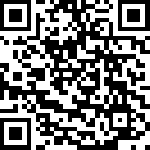
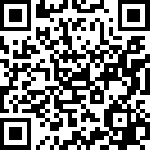

In [34]:
res2

In [35]:
markdowns2 = extractMarkdown(res2, types="all", extract="raw_markdown")
print(f"Number of Markdown Page : {len(markdowns2)}")

Markdown: [![easeweather.com](https://www.easeweather.com/images/easeweather.com.svg)](https://www.easeweather.com)
Units
°C
°F
Hong Kong
[Forecast](https://www.easeweather.com/asia/hong-kong) [Today](https://w...
Markdown: ![Hong Kong Observatory Logo](https://www.hko.gov.hk/textonly/images_e/logo_dblue.gif)
# Current Weather
Bulletin updated at 23:02 HKT 09/Sep/2025
```
At 11 p.m. at Hong Kong Observatory :
Air Tempera...
Markdown: [Skip to main content](https://www.hko.gov.hk/en/wxinfo/currwx/fnd.htm#mainContentSkip "Skip to main content")
[![Hong Kong Observatory](https://www.hko.gov.hk/images/logo_hko_inside_e.png)](https://w...
Markdown: [跳至主要內容](https://www.weather.gov.hk/tc/index.html#ps0 "跳至主要內容")
[![香港天文台](https://www.weather.gov.hk/images/logo_hko_index_c.png)](https://www.weather.gov.hk/tc/index.html)
個人版網站![個人版網站](https://www.w...
Markdown: [ Go Back ](https://www.accuweather.com/pwa)
  * [ For Business ](https://afb.accuweather.com)
  * |
  * [ Warnings ](https://afb.accu

In [36]:
Markdown(markdowns2[1][:2000])

![Hong Kong Observatory Logo](https://www.hko.gov.hk/textonly/images_e/logo_dblue.gif)
# Current Weather
Bulletin updated at 23:02 HKT 09/Sep/2025
```
At 11 p.m. at Hong Kong Observatory :
Air Temperature : 28 degrees Celsius
Relative Humidity : 87 per cent
Weather Cartoon : No. 62 - Light Rain 

The air temperatures at other places were:
King's Park           27 degrees;
Wong Chuk Hang         28 degrees;
Ta Kwu Ling           27 degrees;
Lau Fau Shan          27 degrees;
Tai Po             27 degrees;
Sha Tin             27 degrees;
Tuen Mun            27 degrees;
Tseung Kwan O          27 degrees;
Sai Kung            28 degrees;
Cheung Chau           27 degrees;
Chek Lap Kok          29 degrees;
Tsing Yi            27 degrees;
Shek Kong            26 degrees;
Tsuen Wan Ho Koon        26 degrees;
Tsuen Wan Shing Mun Valley   26 degrees;
Hong Kong Park         28 degrees;
Shau Kei Wan          28 degrees;
Kowloon City          27 degrees;
Happy Valley          29 degrees;
Wong Tai Sin          27 degrees;
Stanley             28 degrees;
Kwun Tong            27 degrees;
Sham Shui Po          27 degrees;
Kai Tak Runway Park       28 degrees;
Yuen Long Park         27 degrees;
Tai Mei Tuk           27 degrees.

Between 9:45 and 10:45 p.m., the rainfall recorded in various regions were:


Kwun Tong          0 to 7 mm;
Yuen Long          0 to 4 mm;
Sai Kung          0 to 3 mm;
Tai Po           0 to 2 mm;
Kowloon City        0 to 1 mm;
Kwai Tsing         0 to 1 mm;
North District       0 to 1 mm;
Tsuen Wan          0 to 1 mm;
Tuen Mun          0 to 1 mm;
Wong Tai Sin        0 to 1 mm.
    

```
| [Copyright and Disclaimer](https://www.hko.gov.hk/textonly/v2/readme.htm) | [Home](https://www.hko.gov.hk/textonly/v2/index.htm) | [Chinese Version / 中文版本](https://www.hko.gov.hk/textonly/v2/forecast/chinesewx2.htm) | [![Current Weather Report RSS](https://www.hko.gov.hk/img/rss3.gif)](http://rss.weather.gov.hk/rss/CurrentWeather.xml) | 
[![遵守2A級無障礙圖示，萬維網聯盟（W3C）- 無障礙網頁倡議（WAI） We

## Start Crewai AI Agent Framework

In [58]:
# set LLM model for AI agent
if CFG.USE_OLLAMA:
    llm =LLM(
        model=CFG.ollamallmModel5,
        temperature=0.7,
        max_tokens=CFG.max_tokens,       
    )



### Define AI agent tool

In [59]:
def agent_step_Callback(stepout):
    """
    Callback function for agent step.
    """
    print(f"Agent Step callback: type {type(stepout)} , step: {stepout} ")


def task_callback(taskout):
    """
    Callback function for task.
    """
    logger.info(f"""Task callback:\n
                     ask Agent Name : {taskout.agent}\n
                    task description: {taskout.description}\n
                    task summary: {taskout.summary}\n
                    output: {taskout.raw} """)

In [ ]:
if CFG.USE_OPIK:
    # Set
    @track(name="Chat Completion", project_name=opikProjectName)
    async def Complation(msg):
        """Asynchronous chat completion function.
        """
        # global stream
        stream = CFG.stream
        if CFG.USE_OLLAMA:
            model = CFG.ollamallmModel5
            apikey = None
            baseURL = CFG.api_base1
            

        if stream == True:
            streamOption = ChatCompletionStreamOptionsParam(include_usage=True) 
        else:
            streamOption = None

        res = await acompletion(   
            model=model,
            messages=msg,

            stream=stream,
            stream_options=streamOption,

            max_tokens=CFG.max_tokens,
            top_p=CFG.top_p,
            temperature=CFG.temperature,
            presence_penalty=CFG.presence_penalty,
            frequency_penalty=CFG.frequency_penalty,
            api_key=apikey,
            base_url=baseURL

        )
        return res
else:
     @track(name="Chat Completion", project_name=opikProjectName)
    async def Complation(msg):
        """Asynchronous chat completion function.
        """
        # global stream
        stream = CFG.stream
        if CFG.USE_OLLAMA:
            model = CFG.ollamallmModel5
            apikey = None
            baseURL = CFG.api_base1
            

        if stream == True:
            streamOption = ChatCompletionStreamOptionsParam(include_usage=True) 
        else:
            streamOption = None

        res = await acompletion(   
            model=model,
            messages=msg,

            stream=stream,
            stream_options=streamOption,

            max_tokens=CFG.max_tokens,
            top_p=CFG.top_p,
            temperature=CFG.temperature,
            presence_penalty=CFG.presence_penalty,
            frequency_penalty=CFG.frequency_penalty,
            api_key=apikey,
            base_url=baseURL

        )
        return res



        

NameError: name 'opikProjectName' is not defined

In [61]:
# Custom web search tool for AI Agent


In [447]:
# Custom web scraping tool for AI Agent

In [448]:
# Initialize tools
scrape_tool = ScrapeWebsiteTool()
search_tool = SerperDevTool()

In [449]:
# Define Agents
market_researcher = Agent(
    role="Market Researcher",
    goal="Gather and analyze real estate market trends from web and news sources",
    backstory="You are an expert in real estate market analysis with a keen eye for identifying trends, price movements, and emerging opportunities. You use web search and scraping to collect relevant data.",
    # tools=[search_tool, scrape_tool],
    llm=llm,
    verbose=True
)

social_media_analyst = Agent(
    role="Social Media Analyst",
    goal="Analyze social media platforms (LinkedIn, Facebook, Instagram) for real estate discussions and user preferences",
    backstory="You specialize in extracting insights from social media platforms, identifying user sentiments, and detecting real estate preferences from posts and comments.",
    # tools=[search_tool],
    llm=llm,
    verbose=True
)

data_analyst = Agent(
    role="Data Analyst",
    goal="Process and clean data from market and social media sources to identify key patterns",
    backstory="You are a data scientist skilled in cleaning, structuring, and analyzing complex datasets to uncover actionable insights for real estate recommendations.",
    llm=llm,
    verbose=True
)

recommendation_engineer = Agent(
    role="Recommendation Engineer",
    goal="Generate personalized real estate recommendations based on user preferences and market data",
    backstory="You are an AI engineer specializing in recommendation systems, capable of synthesizing market and user data to provide tailored property suggestions.",
    llm=llm,
    verbose=True
)


In [450]:
# Define Tasks
market_research_task = Task(
    description="""Search the web and scrape relevant websites for recent real estate market trends, including price changes, demand patterns, and emerging neighborhoods. Focus on a specific city (e.g., New York). Summarize findings in a concise report.""",
    expected_output="A JSON object containing market trends, including average prices, demand indicators, and notable neighborhoods.",
    agent=market_researcher
)

social_media_task = Task(
    description="""Search LinkedIn and Facebook for posts and discussions related to real estate in the target city (e.g., New York). Identify user preferences, such as desired property types (e.g., apartments, houses), budget ranges, and preferred locations. Summarize insights in a structured format.""",
    expected_output="A JSON object summarizing user preferences from social media, including property types, budget ranges, and preferred locations.",
    agent=social_media_analyst
)

data_analysis_task = Task(
    description="""Combine data from market research and social media analysis. Clean and structure the data, identifying key patterns such as high-demand property types and budget-aligned neighborhoods. Output a structured dataset ready for recommendation.""",
    expected_output="A JSON object with cleaned and analyzed data, highlighting key patterns and correlations.",
    agent=data_analyst
)

recommendation_task = Task(
    description="""Using the analyzed data, generate personalized real estate recommendations for users seeking properties in the target city. Recommendations should include property type, location, and estimated price range, tailored to user preferences and market trends.""",
    expected_output="A JSON object containing a list of recommended properties with details (type, location, price range).",
    agent=recommendation_engineer
)

In [451]:
real_estate_crew = Crew(
    agents=[market_researcher, social_media_analyst, data_analyst, recommendation_engineer],
    tasks=[market_research_task, social_media_task, data_analysis_task, recommendation_task],
    process=Process.sequential,
    verbose=True
)